Building on the amazing work by **Can Ozensoy**. You can find his original notebook here: https://www.kaggle.com/code/canozensoy/ps-s5e7-personality-classification-with-xgboost

I have added the data cleaning and few data prep steps. In the next version, I'll add the feature understanding, feautre selection, feature engineering and hyperparameter tunign steps.

<font color = "DeepSkyBlue">**XGBoost: "Yes, it's me. What a shock, etcetera."**

This notebook provides a complete baseline solution using the XGBoost algorithm to classify individuals as Introverts or Extroverts based on personality and social behavior features. It is designed for the July 2025 Kaggle Playground Series competition, where the objective is to predict the Personality target variable with maximum accuracy.

The workflow begins by importing necessary Python libraries such as pandas, NumPy, scikit-learn, and XGBoost. Then, it loads the provided training, test, and sample submission CSV files from the competition’s dataset directory. The Personality column in the training data, which contains string labels (Introvert, Extrovert), is encoded into numerical format using LabelEncoder to make it suitable for model training.

To ensure consistent preprocessing, the training and test feature sets are concatenated. All categorical columns are identified and encoded using OrdinalEncoder, which assigns integer values to string categories. After encoding, the data is split back into training and test sets.

The model is built using XGBoost with a basic set of hyperparameters. These include a maximum tree depth of 4 and a learning rate (eta) of 0.1. Stratified 5-fold cross-validation is used to ensure robust evaluation while preserving the class distribution. In each fold, the model is trained on a portion of the data and validated on a held-out set, and early stopping is applied to avoid overfitting.

After training, the notebook calculates the cross-validation accuracy based on the out-of-fold predictions. It then averages the predictions made on the test set across all folds. These final predictions are thresholded, converted back to the original string labels using the earlier label encoder, and inserted into the submission template.

Finally, the notebook writes the predictions to a submission.csv file, which is ready to be uploaded to Kaggle for evaluation. This solution serves as a clean and efficient starting point. It can be improved further with feature engineering, more advanced models, or ensemble methods.

<font color = "DeepSkyBlue">**Imports**

In the first step, the necessary Python libraries are imported. pandas and numpy are used for data manipulation and numerical operations. StratifiedKFold from sklearn.model_selection is used to perform stratified cross-validation, which ensures that each fold maintains the original class distribution. LabelEncoder and OrdinalEncoder from sklearn.preprocessing are used to convert categorical variables into numerical format for modeling. accuracy_score from sklearn.metrics is used to evaluate the model's performance. Lastly, xgboost is imported to train the XGBoost classifier, which will be used to predict whether a person is an Introvert or an Extrovert.

In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score

!pip install xgboost
import xgboost as xgb

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


<font color = "DeepSkyBlue">**Load data**

In this step, the training, test, and sample submission datasets are loaded using pandas. The train.csv file contains both the input features and the target variable (Personality) used to train the model. The test.csv file contains only the input features and is used for generating predictions. The sample_submission.csv file provides the correct format for submitting predictions to the competition. These datasets are read directly from the Kaggle input directory and stored in three separate DataFrame objects: train, test, and submission.

In [ ]:
# 2. Load data
train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s5e7/sample_submission.csv")

**Data Understanding and Cleaning**

- Identify the categorical columns and numerical columns<br>
- See what categories are present in each of categorical columns. Also take record count against each category.<br>
- See the distribution of numerical columns
- Check for outliers in numerical columns. Cap them.
- Check for missing values in categorical columns.
- Check for missing values in numerical columns
- See if the missing values are missing at random or not completely at random
- Do the missing value treatment using KNN imputer


In the two cells, we are preparing our data for machine learning by identifying which columns are categorical (contain text or categories) and which are numerical (contain numbers). This distinction is important because different types of data require different preprocessing steps.

First, we create two lists: one for categorical columns and one for numerical columns. Then, for each categorical column, we visualize the frequency of each category using bar plots. This helps us understand the distribution of categories in our data, spot any imbalances, and get a sense of what kind of preprocessing or encoding might be needed before training a machine learning model.

In [ ]:
categorical_columns = train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = train.select_dtypes(include=['number']).columns.tolist()

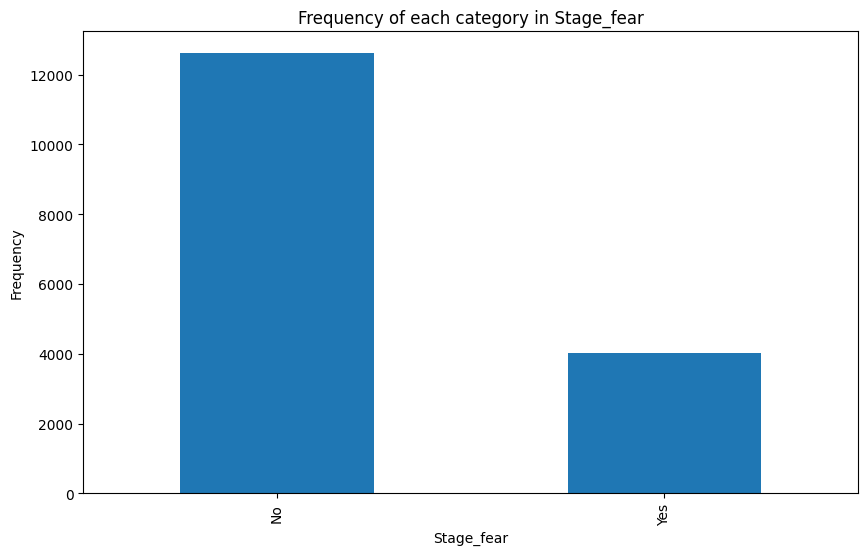

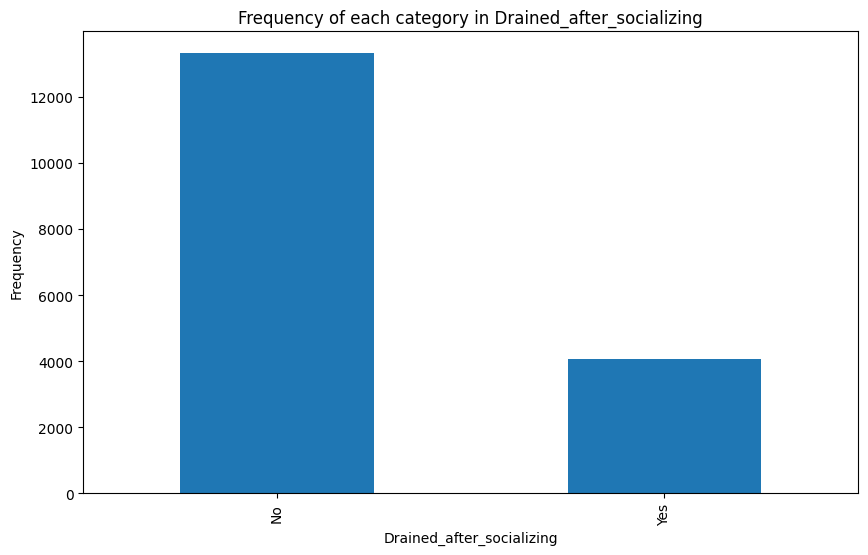

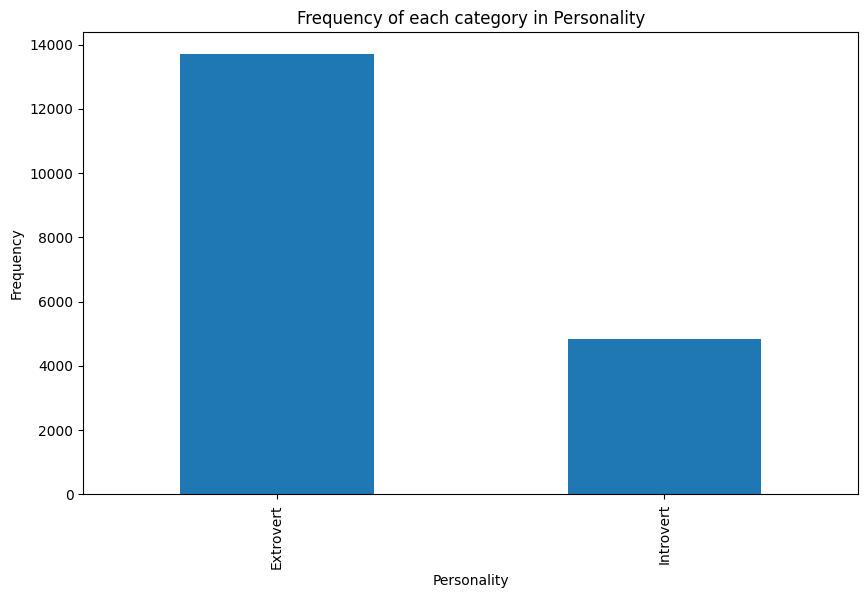

In [ ]:
import matplotlib.pyplot as plt

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    train[col].value_counts().plot(kind='bar')
    plt.title(f'Frequency of each category in {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

>**_Class Imbalance Detected_**

##### Outlier Detection

In this step, we are identifying outliers in the numerical columns of our dataset. Outliers are data points that are significantly different from most other values in a column. Detecting outliers is important because they can skew the results of machine learning models and affect their performance. 

A common way to spot outliers is by using box plots, which visually display the distribution of data and highlight any values that fall outside the typical range. By examining these plots, we can decide whether to keep, remove, or transform outlier values before moving on to model training.

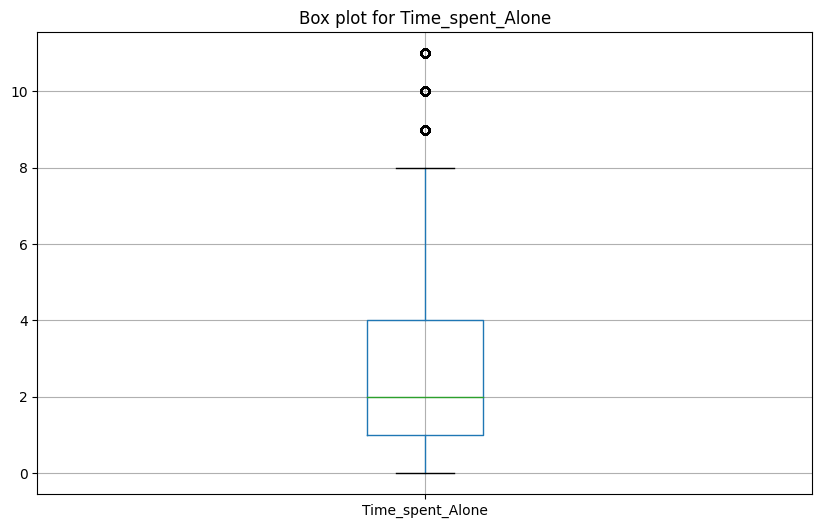

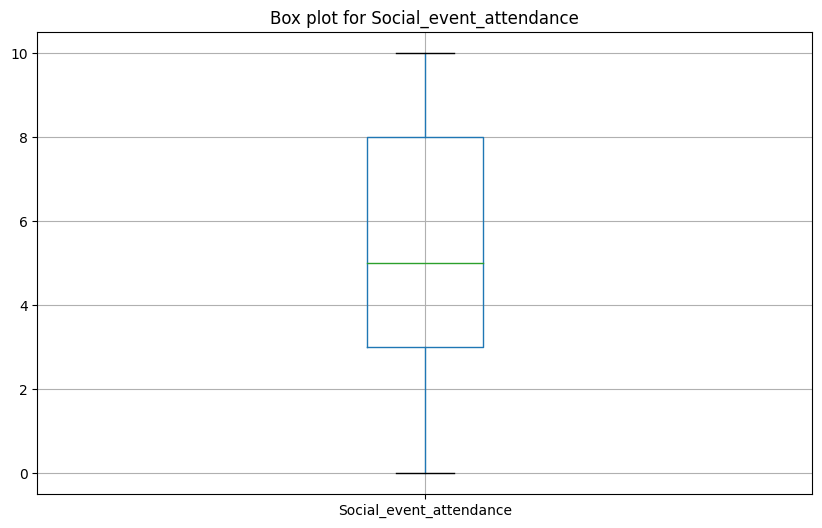

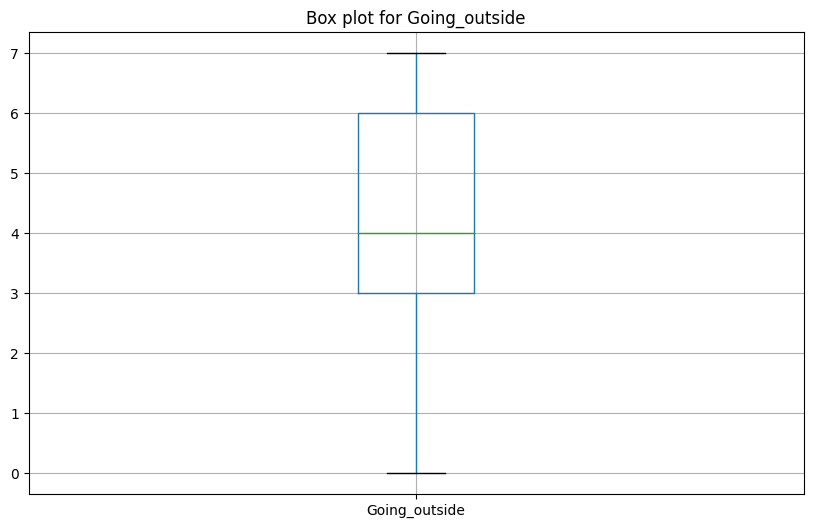

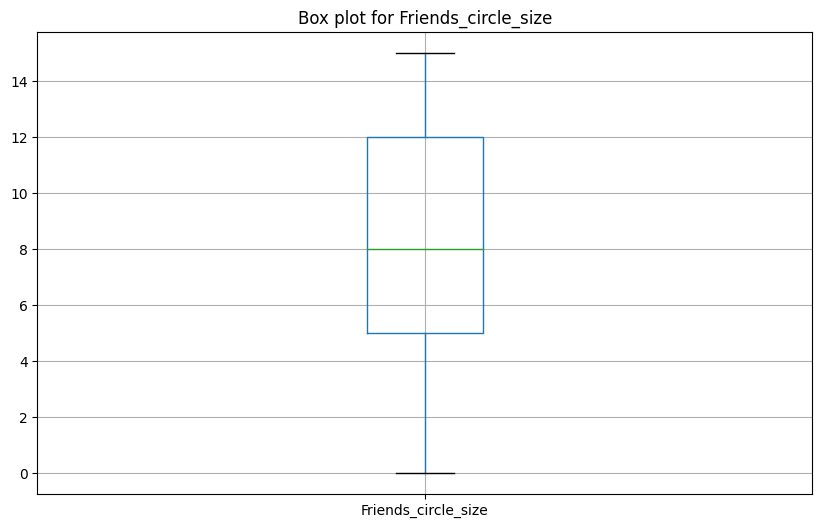

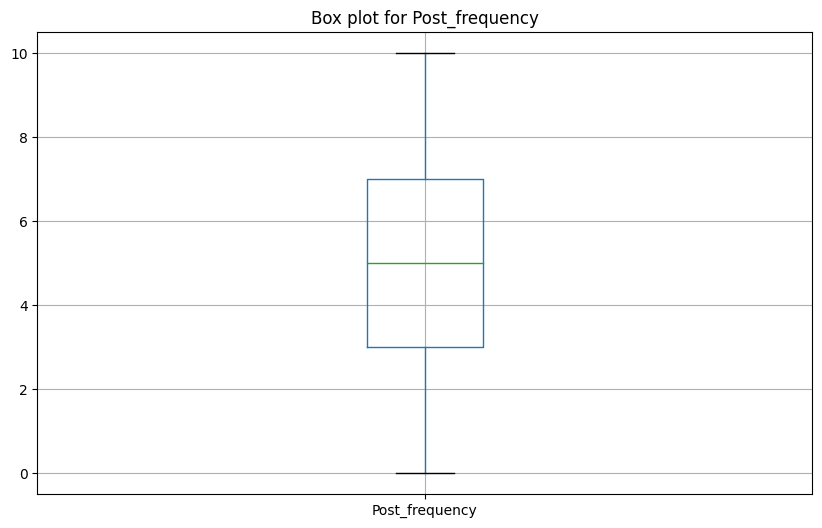

Number of outliers detected by Z-score method: 0
Number of outliers detected by IQR method: 1653


id Time_spent_Alone Stage_fear Social_event_attendance Going_outside Drained_after_socializing Friends_circle_size Post_frequency Personality 25 9.0 Yes 1.0 3.0 Yes 7.0 5.0 Introvert 27 9.0 null 0.0 0.0 Yes 1.0 1.0 Introvert 44 9.0 Yes 1.0 0.0 Yes 3.0 0.0 Introvert 48 10.0 Yes 1.0 null Yes 5.0 1.0 Introvert 55 9.0 Yes 0.0 null Yes 2.0 1.0 Introvert 60 9.0 Yes 4.0 0.0 Yes 2.0 0.0 Introvert 64 9.0 null 2.0 2.0 Yes 1.0 0.0 Introvert 76 10.0 Yes 0.0 2.0 Yes 1.0 1.0 Introvert 83 9.0 Yes null 3.0 Yes 4.0 0.0 Introvert 87 11.0 null 0.0 2.0 Yes 1.0 2.0 Introvert 92 10.0 null 1.0 2.0 Yes 1.0 0.0 Introvert 96 9.0 null 1.0 3.0 Yes 4.0 3.0 Introvert 108 9.0 No 6.0 6.0 No 15.0 4.0 Extrovert 119 10.0 Yes null 2.0 Yes 4.0 0.0 Introvert 121 9.0 Yes 3.0 null Yes 0.0 1.0 Introvert 130 10.0 Yes 0.0 null Yes 0.0 0.0 Introvert 139 11.0 null 2.0 2.0 Yes 2.0 2.0 Extrovert 155 10.0 Yes 0.0 1.0 Yes null 2.0 Introvert 156 10.0 Yes 0.0 0.0 Yes 4.0 2.0 Introvert 158 11.0 Yes 0.0 2.0 null 4.0 null Introvert 159 10.0 null 3.0 0.0 Yes 2.0 0.0 Introvert 179 10.0 Yes 0.0 2.0 null 4.0 0.0 Introvert 182 11.0 Yes 4.0 1.0 Yes 1.0 0.0 Introvert 187 10.0 Yes 2.0 3.0 Yes 3.0 1.0 Introvert 211 10.0 Yes 3.0 1.0 Yes null 1.0 Introvert 220 9.0 null 1.0 0.0 Yes 0.0 0.0 Introvert 232 11.0 Yes 1.0 0.0 Yes 4.0 2.0 Introvert 234 11.0 Yes 2.0 1.0 Yes null null Introvert 236 9.0 Yes 1.0 0.0 null 3.0 0.0 Introvert 238 11.0 Yes 2.0 2.0 Yes 1.0 null Introvert 239 11.0 Yes 3.0 1.0 Yes 4.0 3.0 Introvert 245 10.0 No 3.0 5.0 No 5.0 4.0 Introvert 249 10.0 Yes 1.0 2.0 null 2.0 2.0 Introvert 252 10.0 null 0.0 1.0 Yes 2.0 0.0 Introvert 259 10.0 Yes 2.0 1.0 Yes 1.0 3.0 Introvert 265 10.0 Yes 0.0 2.0 Yes 0.0 3.0 Introvert 268 9.0 Yes null 2.0 Yes 2.0 2.0 Introvert 288 10.0 Yes 3.0 2.0 null 5.0 2.0 Introvert 293 10.0 Yes 3.0 0.0 null 5.0 0.0 Introvert 294 10.0 null 3.0 1.0 Yes 2.0 1.0 Introvert 295 10.0 Yes 1.0 3.0 Yes 4.0 3.0 Introvert 307 9.0 Yes null null Yes 5.0 2.0 Introvert 309 11.0 Yes 2.0 2.0 Yes 0.0 0.0 Introvert 312 9.0 Yes 1.0 1.0 null 5.0 1.0 Introvert 322 10.0 null 3.0 0.0 Yes 4.0 3.0 Introvert 330 11.0 Yes 2.0 null Yes 4.0 2.0 Introvert 346 10.0 Yes null null Yes 5.0 1.0 Introvert 375 11.0 Yes 0.0 2.0 Yes null 0.0 Introvert 384 9.0 Yes 0.0 0.0 Yes 10.0 2.0 Introvert 386 10.0 Yes 3.0 1.0 Yes 5.0 null Introvert 418 9.0 Yes 2.0 2.0 null 2.0 1.0 Introvert 442 11.0 Yes 0.0 3.0 Yes 2.0 0.0 Introvert 449 9.0 Yes 0.0 0.0 null 2.0 1.0 Introvert 468 10.0 null 3.0 0.0 Yes null null Introvert 470 11.0 Yes 1.0 null Yes 2.0 1.0 Introvert 480 9.0 Yes 4.0 2.0 Yes 3.0 2.0 Introvert 498 11.0 Yes 3.0 null Yes 3.0 1.0 Introvert 501 9.0 Yes 0.0 3.0 Yes 4.0 0.0 Introvert 503 11.0 Yes 1.0 2.0 null 3.0 1.0 Extrovert 514 11.0 null 2.0 0.0 null 5.0 0.0 Introvert 518 11.0 Yes 1.0 1.0 Yes 4.0 3.0 Extrovert 536 11.0 Yes 0.0 3.0 Yes 0.0 2.0 Introvert 549 10.0 Yes 0.0 null Yes 4.0 null Introvert 560 10.0 null 2.0 1.0 Yes 3.0 2.0 Introvert 564 10.0 Yes 2.0 3.0 Yes 5.0 1.0 Introvert 577 11.0 null null 1.0 Yes 5.0 2.0 Introvert 583 10.0 null 3.0 0.0 Yes 0.0 1.0 Introvert 586 9.0 Yes 0.0 1.0 Yes 1.0 1.0 Introvert 621 9.0 null 3.0 2.0 Yes 5.0 2.0 Introvert 635 10.0 Yes null 2.0 Yes 5.0 2.0 Introvert 650 9.0 Yes null 2.0 Yes 3.0 1.0 Introvert 651 11.0 Yes 2.0 3.0 Yes 4.0 3.0 Extrovert 655 9.0 Yes null 0.0 Yes 3.0 1.0 Extrovert 657 10.0 Yes 3.0 0.0 Yes 5.0 2.0 Introvert 691 10.0 Yes 2.0 0.0 Yes 5.0 3.0 Introvert 700 10.0 null 0.0 null Yes 5.0 1.0 Introvert 702 9.0 Yes 0.0 0.0 Yes 3.0 4.0 Introvert 722 10.0 Yes null 0.0 Yes 4.0 2.0 Introvert 730 9.0 null 0.0 1.0 Yes 4.0 0.0 Introvert 762 10.0 Yes 2.0 2.0 Yes null 0.0 Introvert 775 9.0 Yes null 2.0 Yes 0.0 0.0 Introvert 784 10.0 Yes 3.0 2.0 Yes 3.0 0.0 Introvert 787 9.0 Yes 1.0 1.0 null 1.0 1.0 Introvert 800 10.0 null 0.0 2.0 Yes 1.0 1.0 Introvert 809 11.0 Yes 2.0 0.0 Yes 1.0 3.0 Introvert 816 9.0 Yes null null Yes 1.0 2.0 Introvert 823 10.0 Yes 3.0 0.0 null 1.0 1.0 Introvert 849 11.0 null 0.0 1.0 Yes 3.0 2.0 Introvert 856 9.0 Yes 2.0 3.0 Yes 5.0 1.0 Introvert 858 1

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt

# Exclude 'id' column from numerical columns
numerical_columns = [col for col in numerical_columns if col != 'id']

# Box plot for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    train.boxplot(column=col)
    plt.title(f'Box plot for {col}')
    plt.show()

# Z-score method for outlier detection
z_scores = train[numerical_columns].apply(stats.zscore)
outliers_z = (z_scores.abs() > 3).any(axis=1)
print(f'Number of outliers detected by Z-score method: {outliers_z.sum()}')

# IQR method for outlier detection
Q1 = train[numerical_columns].quantile(0.25)
Q3 = train[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((train[numerical_columns] < (Q1 - 1.5 * IQR)) | (train[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f'Number of outliers detected by IQR method: {outliers_iqr.sum()}')

# Display rows identified as outliers by either method
outliers_combined = outliers_z | outliers_iqr
display(train[outliers_combined])

Box Plots don't show any values that are too extreme

<font color = "DeepSkyBlue">**Encode target**

In this step, the target variable Personality, which contains categorical values (Introvert or Extrovert), is converted into numerical format using LabelEncoder. This encoding is necessary because machine learning models like XGBoost require numerical inputs. A new column named Personality_encoded is added to the training dataset, where Introvert and Extrovert are represented as integers (0 and 1, or vice versa).

In [ ]:
# 3. Encode target
le = LabelEncoder()
train["Personality_encoded"] = le.fit_transform(train["Personality"])

<font color = "DeepSkyBlue">**Prepare features**

In this step, the input features and target variable are separated for model training. The features DataFrame X is created by dropping the id, Personality, and Personality_encoded columns from the training set, since id is not a predictive feature and the target columns should not be included as inputs. The target variable y is assigned from the Personality_encoded column. Similarly, the test set features X_test are prepared by removing the id column, keeping only the relevant input features for prediction.

In [ ]:
# 4. Prepare features
X = train.drop(columns=["id", "Personality", "Personality_encoded"])
y = train["Personality_encoded"]
X_test = test.drop(columns=["id"])

<font color = "DeepSkyBlue">**Encode categorical columns**

In this step, categorical features are identified and transformed into numerical values. First, the training and test feature sets (X and X_test) are concatenated vertically into a single DataFrame named combined to ensure consistent encoding across both datasets. The code then identifies all columns with object data types (i.e., categorical text columns) and stores their names in cat_cols. An OrdinalEncoder is applied to these columns, converting each unique category into a unique integer. After encoding, the combined data is split back into the original training (X) and test (X_test) feature sets, preserving the original row order.

In [ ]:
# 5. Encode categorical columns
combined = pd.concat([X, X_test], axis=0)
cat_cols = combined.select_dtypes(include="object").columns.tolist()
encoder = OrdinalEncoder()
combined[cat_cols] = encoder.fit_transform(combined[cat_cols])

X = combined.iloc[:len(X)].reset_index(drop=True)
X_test = combined.iloc[len(X):].reset_index(drop=True)

In [ ]:
X

Time_spent_Alone  Stage_fear  ...  Friends_circle_size  Post_frequency
0                   0.0         0.0  ...                 15.0             5.0
1                   1.0         0.0  ...                 10.0             8.0
2                   6.0         1.0  ...                  3.0             0.0
3                   3.0         0.0  ...                 11.0             5.0
4                   1.0         0.0  ...                 13.0             NaN
...                 ...         ...  ...                  ...             ...
18519               3.0         0.0  ...                  9.0             7.0
18520               1.0         2.0  ...                  6.0             5.0
18521               7.0         1.0  ...                  1.0             NaN
18522               NaN         1.0  ...                  5.0             2.0
18523               1.0         0.0  ...                  4.0             7.0

[18524 rows x 7 columns]

### Missing Value Treatment
<font color = "DeepSkyBlue">**Assessing Missing Data Mechanism: Are Values MCAR?**

In this step, we investigate whether the missing values in our dataset are *Missing Completely At Random* (MCAR). Understanding the missing data mechanism is crucial, as it influences how we handle missing values during preprocessing.

**Step-by-step Tutorial:**

1. **Visualize Missing Data Patterns:**  
   Use libraries like `missingno` or `seaborn` to create heatmaps or bar plots that show where missing values occur. This helps identify if missingness is concentrated in certain columns or rows.

2. **Statistical Tests for MCAR:**  
   Apply statistical tests such as *Little's MCAR test* (available in the `statsmodels` or `missingno` packages) to formally assess if the missingness is independent of both observed and unobserved data.

3. **Compare Distributions:**  
   For each feature with missing values, compare the distribution of other features between rows with and without missing data. If distributions are similar, it supports the MCAR assumption.

4. **Interpret Results:**  
   - If data is MCAR, missingness is unrelated to any variable, and simple imputation methods (like mean/median) are valid.
   - If not MCAR, consider more advanced imputation or modeling techniques.

**Why This Matters:**  
Correctly identifying the missing data mechanism ensures that the chosen imputation strategy does not introduce bias, leading to more reliable machine learning models.

- The second plot in the output is a heatmap of the correlation matrix of missingness in X.
- It shows the pairwise correlations between the missingness indicators of each column.
- High positive values indicate that missing values in one column tend to occur with missing values in another.
- High negative values indicate that missingness in one column is associated with non-missingness in another.
- This helps identify patterns or dependencies in missing data, which can inform imputation strategies.

<Axes: >

{"Little's MCAR test statistic": 1041.749953555598, 'df': 119, 'p-value': 0.0}

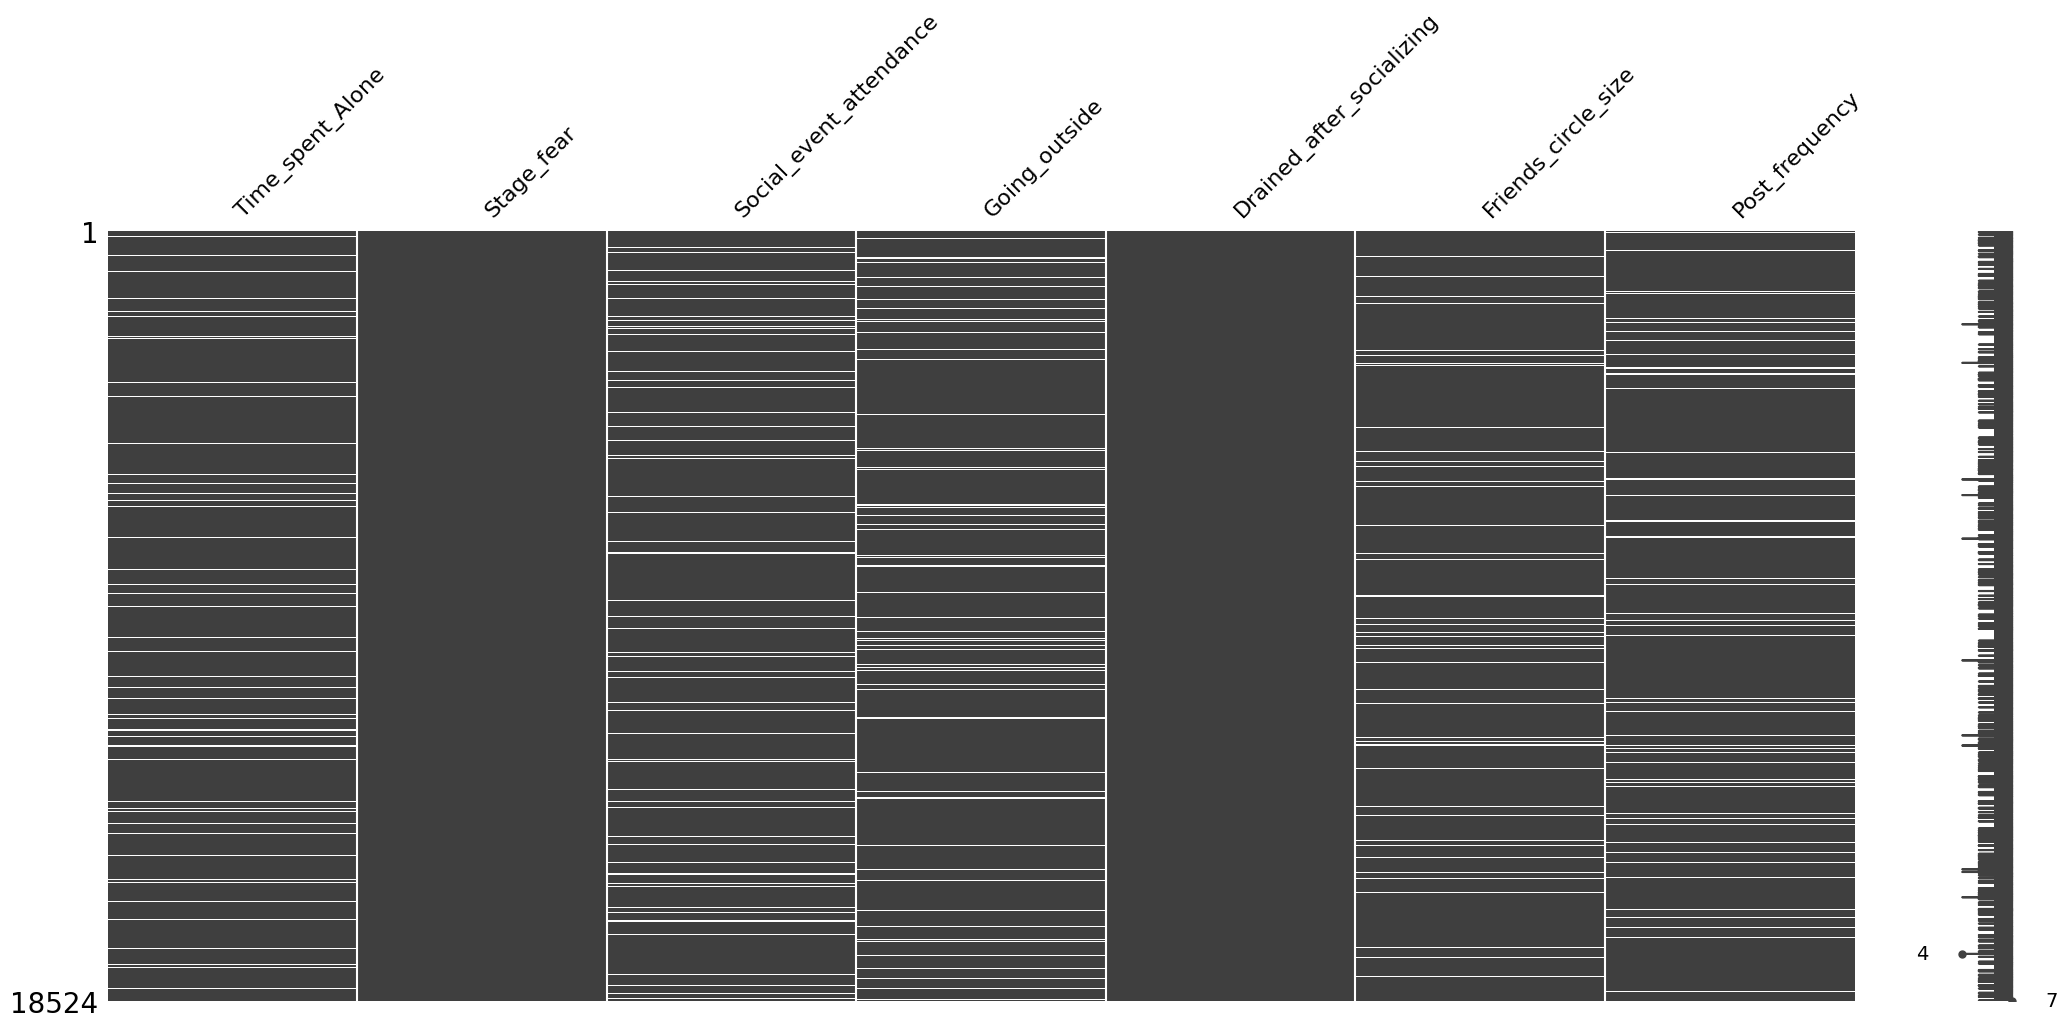

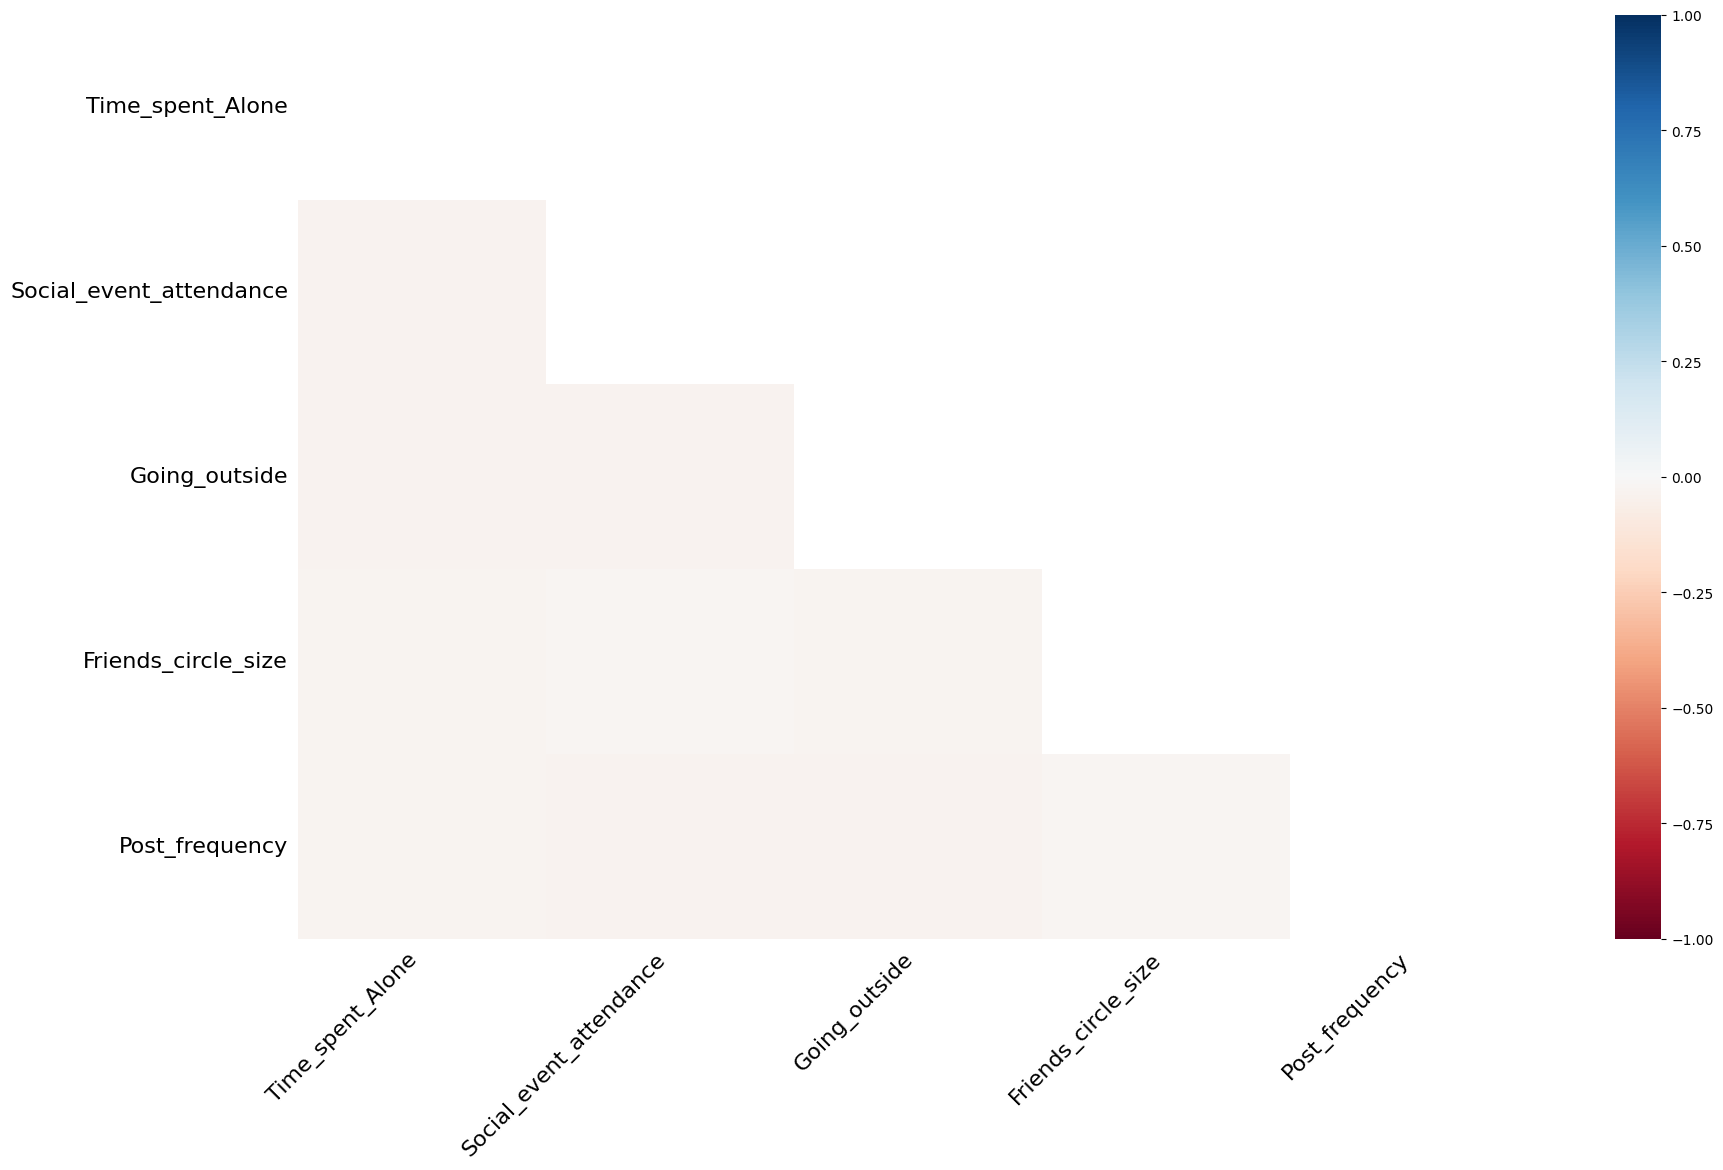

In [ ]:
# !pip install missingno
import missingno as msno
import scipy.stats as stats

# Visualize missingness pattern
msno.matrix(X)
display(msno.heatmap(X))

# Little's MCAR test (using statsmodels' implementation)
from statsmodels.imputation import mice

# Little's MCAR test is not directly available in Python, but we can use a workaround:
def littles_mcar_test(df):
    from numpy import isnan
    from scipy.stats import chi2
    import numpy as np

    df = df.copy()
    mask = df.isnull()
    n, p = df.shape
    patterns = mask.drop_duplicates()
    patterns_idx = [np.where((mask == pat).all(axis=1))[0] for _, pat in patterns.iterrows()]
    means = df.mean()
    cov = df.cov()
    stat = 0
    dfree = 0
    for idx in patterns_idx:
        sub = df.iloc[idx]
        obs = ~mask.iloc[idx[0]]
        n_g = len(idx)
        if n_g == 0 or obs.sum() == 0:
            continue
        sub_mean = sub.loc[:, obs].mean()
        mean_diff = sub_mean - means[obs]
        cov_g = cov.loc[obs, obs]
        try:
            inv_cov_g = np.linalg.inv(cov_g)
        except np.linalg.LinAlgError:
            continue
        stat += n_g * mean_diff.T @ inv_cov_g @ mean_diff
        dfree += obs.sum()
    p_value = 1 - chi2.cdf(stat, dfree)
    return stat, dfree, p_value

stat, dfree, p_value = littles_mcar_test(X)
display({"Little's MCAR test statistic": stat, "df": dfree, "p-value": p_value})

<Axes: >

<Axes: >

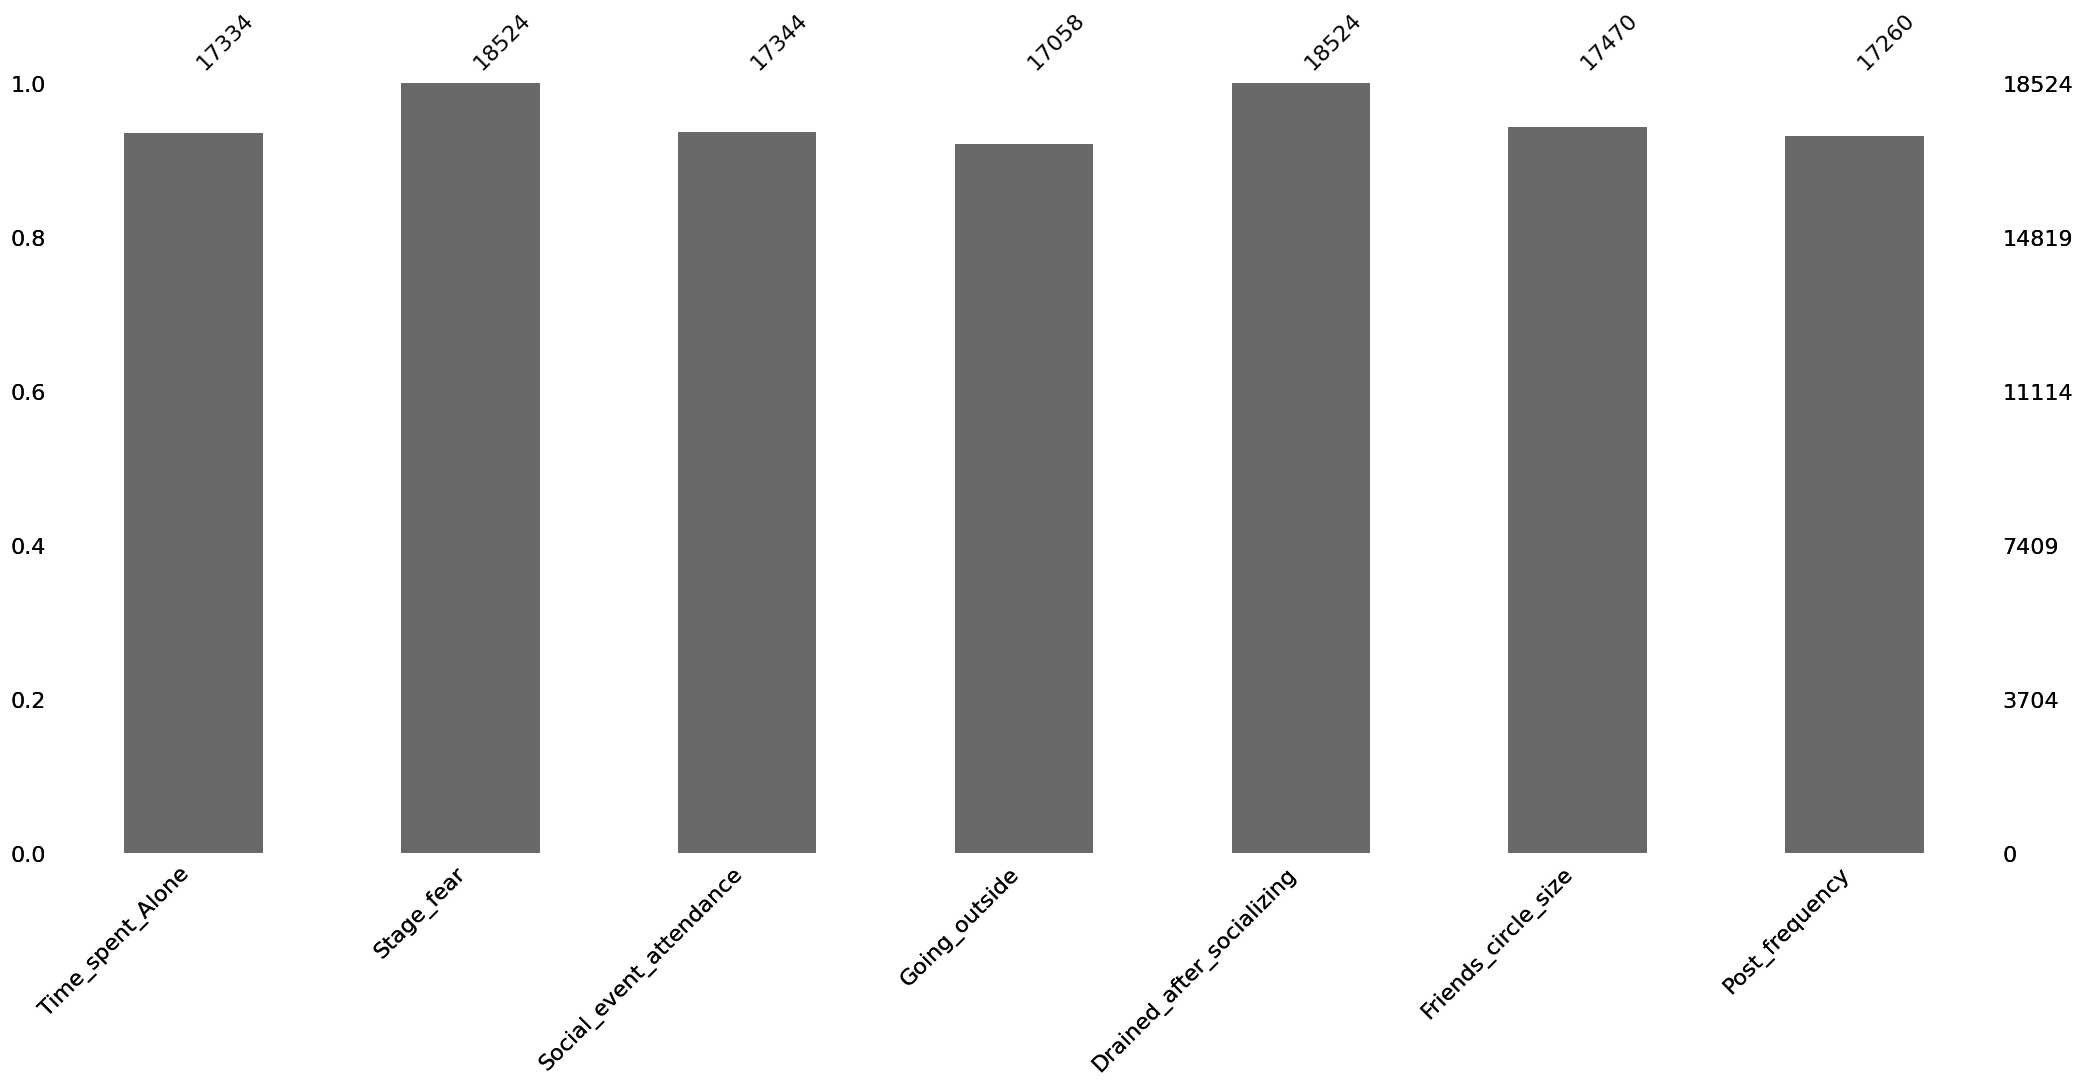

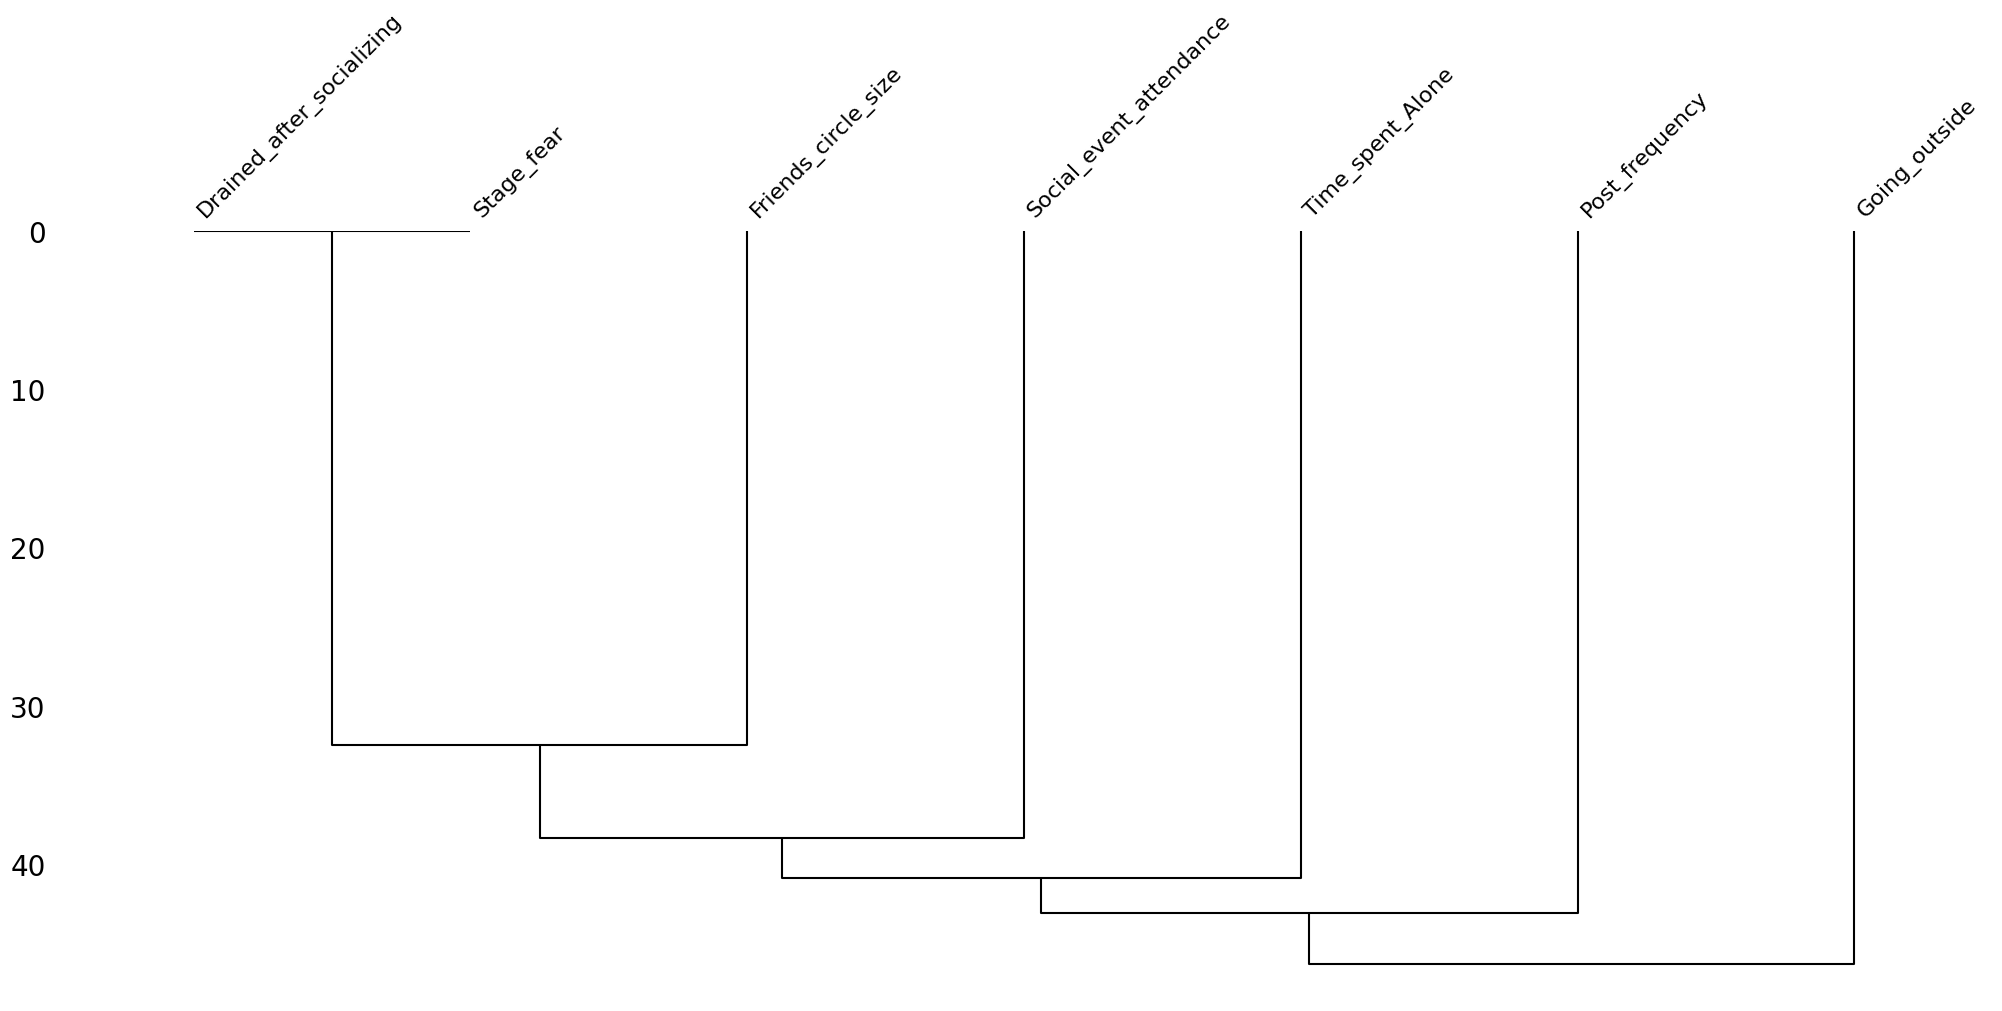

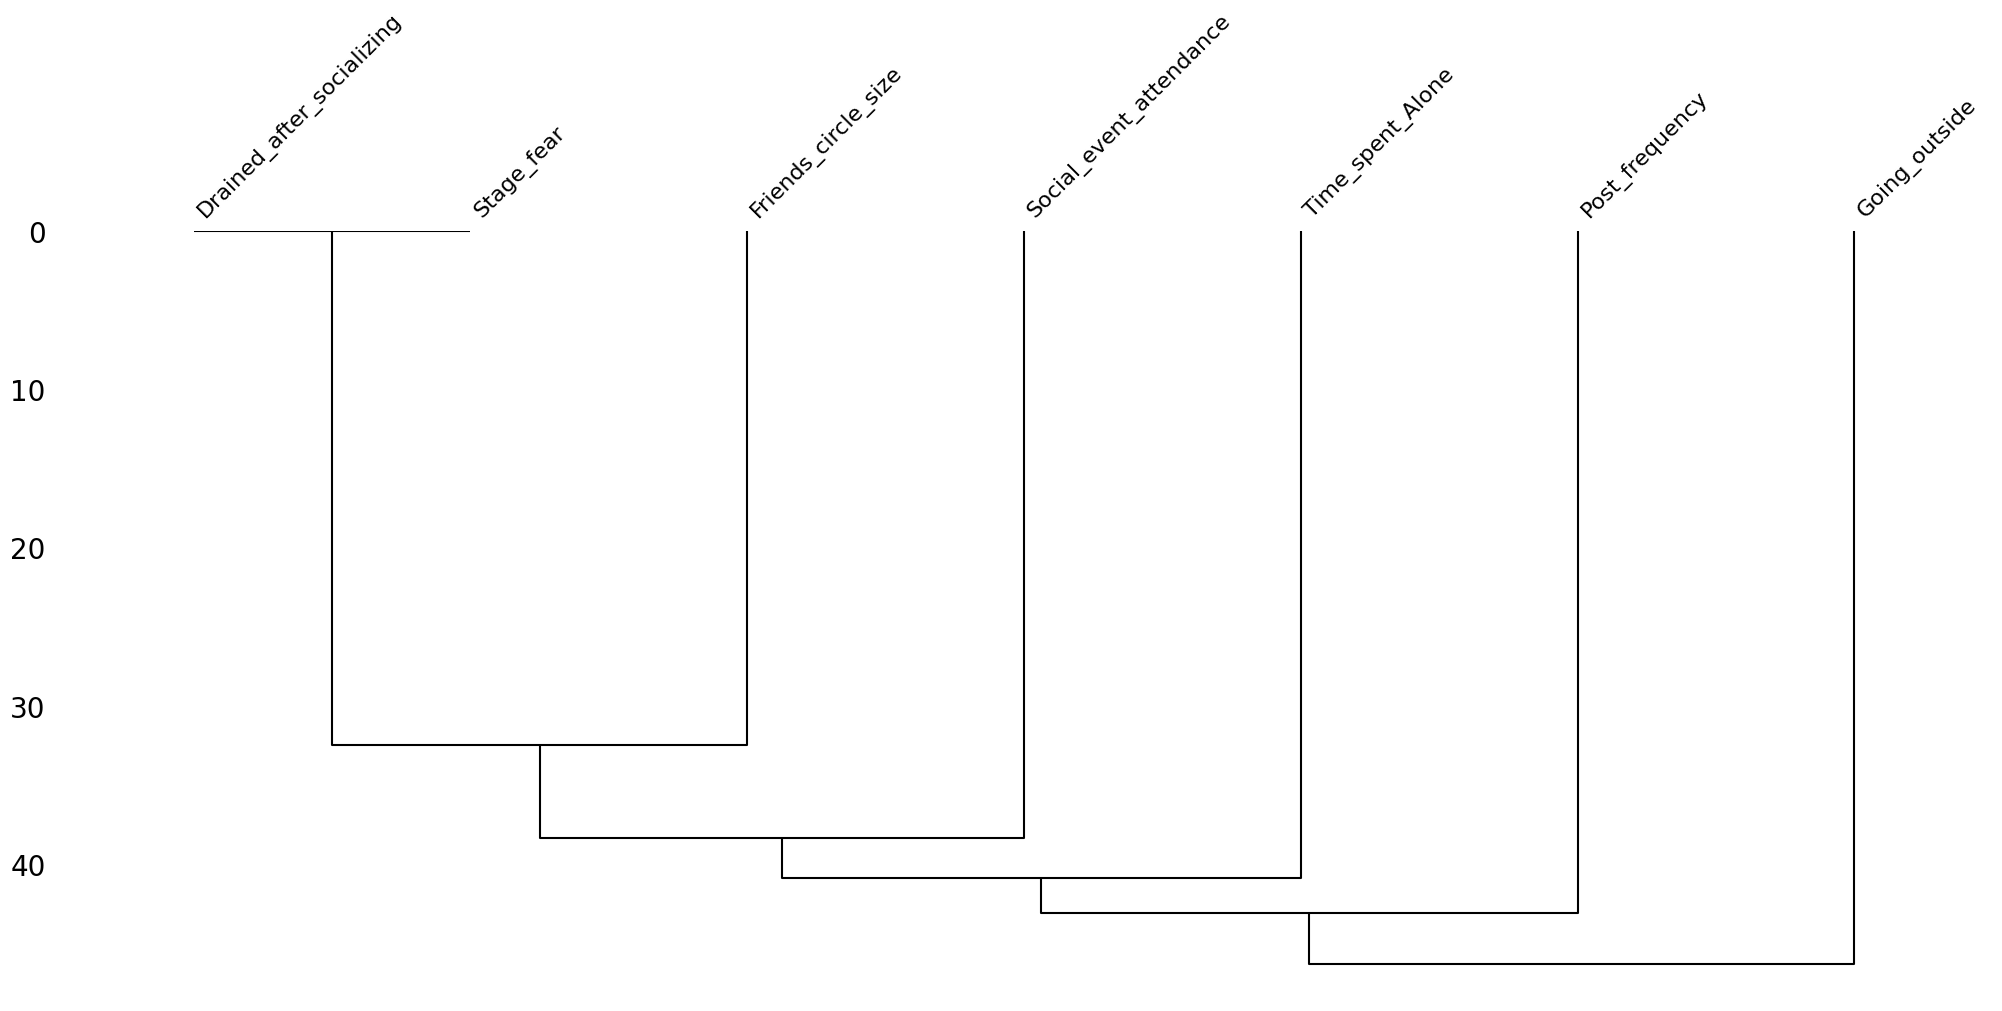

In [ ]:
# Visualize missingness pattern with a bar plot
msno.bar(X)
display(msno.bar(X))

# Visualize missingness pattern with a dendrogram
msno.dendrogram(X)
display(msno.dendrogram(X))

- The first plot is a bar plot showing the count of missing values in each column. It helps quickly identify which features have the most missing data and may require special attention during preprocessing.
- The second plot is a dendrogram that clusters columns based on the similarity of their missingness patterns. Columns that often have missing values together are grouped, revealing potential dependencies or shared causes of missingness.  
  For example, in the dendrogram above, columns like  Stage_fear and Drained_after_socializing are grouped together, indicating that missing values in these features tend to occur simultaneously, possibly due to related survey questions or participant behavior.

In [ ]:
# Interpretation of Little's MCAR test results
if p_value < 0.05:
    interpretation = "The missing data is not Missing Completely At Random (MCAR)."
else:
    interpretation = "The missing data is likely Missing Completely At Random (MCAR)."

display({"Interpretation": interpretation})

{'Interpretation': 'The missing data is not Missing Completely At Random (MCAR).'}

**MCAR or MAR**<br>
- Small Differences: If the differences between the observed and imputed means (and standard deviations) are small, it suggests that the missing data might be MCAR.
- Large Differences: If the differences are large, it suggests that the missing data might be MAR, as the missingness is likely related to other observed variables.

In [ ]:
from statsmodels.imputation.mice import MICEData
import pandas as pd

# Convert the DataFrame to a format suitable for MICE
mice_data = MICEData(X)

# Perform multiple imputations
mice_data.update_all()

# Check if the imputed values are significantly different from the observed values
imputed_data = pd.DataFrame(mice_data.data, columns=X.columns)

# Compare the distributions of the observed and imputed data
comparison = {}
for column in X.columns:
    observed = X[column].dropna()
    imputed = imputed_data[column][X[column].isna()]
    comparison[column] = {
        "observed_mean": observed.mean(),
        "imputed_mean": imputed.mean(),
        "observed_std": observed.std(),
        "imputed_std": imputed.std()
    }

display(comparison)

/databricks/python/lib/python3.10/site-packages/statsmodels/imputation/mice.py:285: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.data[col].fillna(imp, inplace=True)
/databricks/python/lib/python3.10/site-packages/statsmodels/imputation/mice.py:285: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

{'Time_spent_Alone': {'observed_mean': 3.1377639321564557,
  'imputed_mean': 2.888235294117647,
  'observed_std': 3.0037863347217417,
  'imputed_std': 2.865668612599754},
 'Stage_fear': {'observed_mean': 0.4215072338587778,
  'imputed_mean': nan,
  'observed_std': 0.6695122002620798,
  'imputed_std': nan},
 'Social_event_attendance': {'observed_mean': 5.265106088560886,
  'imputed_mean': 4.686440677966102,
  'observed_std': 2.753359060440941,
  'imputed_std': 2.9126356078172395},
 'Going_outside': {'observed_mean': 4.044319380935631,
  'imputed_mean': 3.6739427012278307,
  'observed_std': 2.0625798113009637,
  'imputed_std': 2.149711403948004},
 'Drained_after_socializing': {'observed_mean': 0.3433383718419348,
  'imputed_mean': nan,
  'observed_std': 0.5912117074315418,
  'imputed_std': nan},
 'Friends_circle_size': {'observed_mean': 7.996737263880939,
  'imputed_mean': 7.222960151802656,
  'observed_std': 4.223483912812513,
  'imputed_std': 4.380371955170825},
 'Post_frequency': {'ob

Here we do the t-test to see how significant the difference is between observed values and imputed values

In [ ]:
threshold = 0.1  # Define a threshold for relative mean difference

mar_status = {}
for column, stats in comparison.items():
    observed_mean = stats["observed_mean"]
    imputed_mean = stats["imputed_mean"]
    if pd.isna(observed_mean) or observed_mean == 0:
        rel_diff = abs(imputed_mean - observed_mean)
    else:
        rel_diff = abs(imputed_mean - observed_mean) / abs(observed_mean)
    
    if pd.isna(imputed_mean):
        mar_status[column] = "No Missing Values"  
    elif rel_diff > threshold:
        mar_status[column] = "Likely MAR (Missing At Random) or MNAR (Not Missing At Random)"
    else:
        mar_status[column] = "Likely MCAR (Missing Completely At Random)"

display(mar_status)

{'Time_spent_Alone': 'Likely MCAR (Missing Completely At Random)',
 'Stage_fear': 'No Missing Values',
 'Social_event_attendance': 'Likely MAR (Missing At Random) or MNAR (Not Missing At Random)',
 'Going_outside': 'Likely MCAR (Missing Completely At Random)',
 'Drained_after_socializing': 'No Missing Values',
 'Friends_circle_size': 'Likely MCAR (Missing Completely At Random)',
 'Post_frequency': 'Likely MAR (Missing At Random) or MNAR (Not Missing At Random)'}

In [ ]:
from scipy.stats import ttest_ind

mar_status = {}
for column, stats in comparison.items():
    observed = X[column].dropna()
    imputed = imputed_data[column][X[column].isna()]

    observed_mean = stats["observed_mean"]
    imputed_mean = stats["imputed_mean"]
    
    p_value = ttest_ind(observed, imputed, nan_policy='omit').pvalue

    if pd.isna(imputed_mean):
        mar_status[column] = "No Missing Values"    
    elif p_value <= 0.01:
        mar_status[column] = f"Likely MAR (Missing At Random) or MNAR (Not Missing At Random)"
        mar_status[column + '_p_value'] = f"{p_value}"
    else:
        mar_status[column] = "Likely MCAR (Missing Completely At Random)"
        mar_status['p_value'] = f"{p_value}"


display(mar_status)

{'Time_spent_Alone': 'Likely MAR (Missing At Random) or MNAR (Not Missing At Random)',
 'Time_spent_Alone_p_value': '0.005439431010375509',
 'Stage_fear': 'No Missing Values',
 'Social_event_attendance': 'Likely MAR (Missing At Random) or MNAR (Not Missing At Random)',
 'Social_event_attendance_p_value': '3.530796187333718e-12',
 'Going_outside': 'Likely MAR (Missing At Random) or MNAR (Not Missing At Random)',
 'Going_outside_p_value': '4.982995018452824e-11',
 'Drained_after_socializing': 'No Missing Values',
 'Friends_circle_size': 'Likely MAR (Missing At Random) or MNAR (Not Missing At Random)',
 'Friends_circle_size_p_value': '8.352582643515409e-09',
 'Post_frequency': 'Likely MAR (Missing At Random) or MNAR (Not Missing At Random)',
 'Post_frequency_p_value': '3.7426089388117903e-13'}

Now we find to missing values which columns the MAR values of a given column are correlated

In [ ]:
from scipy.stats import ttest_ind

columns_to_test = ["Social_event_attendance", "Going_outside", "Post_frequency"]
mar_mnar_results = {}

for col in columns_to_test:
    missing_mask = X[col].isna()
    for other_col in X.columns:
        if other_col == col:
            continue
        observed = X.loc[~missing_mask, other_col].dropna()
        missing = X.loc[missing_mask, other_col].dropna()
        if len(observed) > 0 and len(missing) > 0:
            stat, pval = ttest_ind(observed, missing, equal_var=False)
            if pval < 0.05:
                mar_mnar_results.setdefault(col, []).append(
                    f"Missingness in {col} is associated with {other_col} (p={pval:.3g}) → Likely MAR"
                )
    if col not in mar_mnar_results:
        mar_mnar_results[col] = ["No significant association with other variables → Possibly MNAR"]

display(mar_mnar_results)

{'Social_event_attendance': ['Missingness in Social_event_attendance is associated with Time_spent_Alone (p=1.88e-09) → Likely MAR',
  'Missingness in Social_event_attendance is associated with Going_outside (p=1.6e-18) → Likely MAR',
  'Missingness in Social_event_attendance is associated with Drained_after_socializing (p=5.14e-05) → Likely MAR',
  'Missingness in Social_event_attendance is associated with Friends_circle_size (p=1.15e-10) → Likely MAR',
  'Missingness in Social_event_attendance is associated with Post_frequency (p=4.69e-18) → Likely MAR'],
 'Going_outside': ['Missingness in Going_outside is associated with Time_spent_Alone (p=6.26e-10) → Likely MAR',
  'Missingness in Going_outside is associated with Social_event_attendance (p=5e-13) → Likely MAR',
  'Missingness in Going_outside is associated with Drained_after_socializing (p=0.00306) → Likely MAR',
  'Missingness in Going_outside is associated with Friends_circle_size (p=0.000114) → Likely MAR',
  'Missingness in Go

_Although the statistical test shows that all the columns are MAR I'll go with the manual threshold of 0.1. This is because the data values range suggest that a differnce less than 0.1 should be insignificant. This is my hunch you can go with the statistical tests._

In [ ]:
from sklearn.impute import KNNImputer

# Select columns to impute and their associated columns
mar_columns = ["Social_event_attendance", "Going_outside", "Post_frequency"]
associated_columns = {col: [assoc.split(" is associated with ")[1].split(" (p=")[0] 
                           for assoc in mar_mnar_results[col] if "associated with" in assoc]
                      for col in mar_columns}

# Impute each MAR column using KNNImputer with its associated columns
for col in mar_columns:
    cols_for_impute = [col] + associated_columns[col]
    # Ensure columns exist and are numeric
    cols_for_impute = [c for c in cols_for_impute if c in X.columns and pd.api.types.is_numeric_dtype(X[c])]
    mar_imputer = KNNImputer(n_neighbors=5)
    X[cols_for_impute] = mar_imputer.fit_transform(X[cols_for_impute])

display(X[mar_columns])

Social_event_attendance Going_outside Post_frequency 6.0 4.0 5.0 7.0 3.0 8.0 1.0 0.0 0.0 7.0 3.0 5.0 4.0 4.0 5.0 8.0 5.0 3.0 8.0 4.8 4.0 8.0 3.0 5.0 2.0 1.0 2.0 8.0 6.0 9.0 7.0 4.0 10.0 6.0 3.0 8.0 5.0 4.0 6.0 7.0 5.0 5.0 6.0 4.0 7.2 7.0 6.0 8.0 6.0 4.0 10.0 0.0 4.0 0.0 4.0 4.0 9.0 5.0 5.0 3.0 9.0 3.0 7.0 3.0 2.0 3.0 0.0 1.0 0.0 9.0 7.0 3.0 5.0 3.0 5.0 1.0 3.0 5.0 6.0 5.0 9.0 0.0 0.0 1.0 7.2 4.0 8.0 1.0 0.0 0.0 9.0 0.0 5.0 4.0 4.6 5.0 9.0 5.0 8.0 7.0 5.0 9.0 1.0 0.0 2.0 2.0 3.0 3.0 6.0 3.0 6.0 7.0 4.0 3.0 8.0 3.0 6.0 5.0 4.0 4.0 8.0 3.0 4.0 6.0 5.0 3.0 6.0 6.0 6.0 9.0 4.0 5.0 1.0 0.0 0.0 6.0 5.4 4.0 7.0 3.0 6.0 4.0 7.0 3.0 1.0 1.4 1.0 9.0 7.0 4.0 1.8 2.0 2.0 3.0 6.0 8.0 7.0 6.0 3.0 3.0 3.0 0.0 3.0 1.0 1.0 0.0 1.0 1.0 9.0 7.0 3.0 6.0 3.0 7.0 0.0 2.0 1.8 8.0 6.0 9.0 4.0 0.0 0.0 9.0 3.0 5.0 6.0 6.0 4.0 4.0 2.0 0.0 2.0 2.0 0.0 0.0 2.0 2.0 8.0 4.0 10.0 7.8 7.0 9.0 0.0 2.0 0.0 1.0 0.6 2.0 4.0 3.0 10.0 7.0 4.0 9.0 8.0 6.0 8.0 7.0 5.0 4.0 6.0 6.0 3.0 7.0 5.0 8.0 0.0 2.0 1.0 2.0 3.0 3.0 5.0 4.0 7.0 4.0 4.0 8.0 9.0 4.0 7.4 8.0 5.0 6.0 6.0 7.0 3.0 0.8 3.0 0.0 7.0 6.0 6.0 6.0 4.0 6.0 8.0 3.0 6.0 0.0 2.0 2.0 6.0 4.0 5.8 5.0 5.0 3.0 5.0 6.0 9.0 3.0 7.0 9.0 1.0 2.0 0.0 9.0 7.0 6.0 5.0 6.0 8.0 8.0 6.0 5.0 1.0 3.0 3.0 3.0 0.0 1.0 6.0 5.0 7.0 6.0 3.0 7.0 6.0 5.0 3.0 10.0 6.0 7.0 2.0 0.0 0.0 6.0 6.0 6.0 6.0 6.0 8.0 0.0 2.0 0.0 10.0 4.0 3.0 4.0 4.0 6.0 6.0 6.0 4.0 6.0 5.0 6.0 9.0 4.0 6.0 4.0 3.0 7.0 5.0 3.0 9.0 10.0 4.0 8.0 0.0 3.0 2.0 4.0 4.0 4.0 4.0 5.0 6.0 6.0 5.0 8.0 4.0 6.0 7.0 2.2 2.0 0.0 9.0 3.0 6.2 3.0 1.4 1.0 1.0 0.0 1.0 3.0 1.0 1.8 7.0 6.0 3.0 6.0 3.0 9.0 4.0 7.0 3.0 9.0 4.0 7.0 4.0 6.0 8.0 4.0 4.0 3.0 0.0 1.2 0.0 9.0 4.0 8.0 8.0 5.0 7.0 5.0 7.0 9.0 4.0 6.0 6.0 9.0 6.0 9.0 9.0 3.0 9.0 3.0 3.0 8.0 8.0 7.0 3.0 2.0 2.0 2.0 7.0 6.0 6.0 8.0 6.0 6.0 7.0 4.0 4.0 3.0 6.0 9.0 4.0 4.0 9.0 4.0 5.0 5.4 7.0 4.0 5.2 3.0 1.0 1.8 9.0 3.0 7.0 4.0 6.0 3.0 1.6 1.0 1.0 0.0 2.0 2.0 1.0 2.0 3.0 6.0 3.0 3.0 4.0 7.0 6.0 0.0 1.0 2.0 0.0 0.0 2.0 5.0 5.0 6.0 0.0 2.0 1.8 3.0 0.0 0.0 9.0 5.0 5.0 6.0 5.0 3.0 7.0 7.0 3.0 2.0 0.0 0.0 9.0 3.0 3.0 1.6 0.0 1.0 7.0 3.0 8.0 6.0 4.0 4.0 3.0 2.0 2.0 1.0 1.0 1.0 6.4 3.0 6.0 7.0 4.0 5.6 8.0 6.0 3.0 9.0 6.0 7.0 10.0 3.0 8.0 6.0 5.0 7.0 7.0 3.0 5.0 8.0 4.8 7.0 3.0 6.0 8.0 0.0 2.0 0.0 3.0 1.6 1.0 9.0 3.0 4.0 4.0 1.0 0.0 6.0 7.0 4.0 7.0 4.0 8.0 4.0 4.0 5.0 7.0 4.0 6.0 2.0 3.0 1.0 6.0 4.0 8.0 3.0 1.4 1.0 3.0 2.0 0.0 9.0 4.8 4.0 5.0 5.0 3.0 4.0 4.8 7.0 9.0 6.0 9.0 7.0 5.0 4.0 4.0 5.0 5.0 4.0 6.0 5.0 9.0 3.0 9.0 8.0 4.0 3.0 4.0 5.0 6.2 7.0 4.0 6.0 5.0 5.0 9.0 3.0 7.0 8.0 6.0 5.0 3.0 3.0 1.0 3.0 8.0 3.0 9.0 9.0 6.0 10.0 4.0 3.8 4.0 8.0 3.0 9.0 0.0 2.0 1.0 3.0 1.0 1.0 8.0 3.0 6.8 2.0 1.0 1.0 2.0 0.0 0.0 6.0 5.2 9.0 1.0 2.0 1.0 8.0 5.0 4.0 9.0 6.0 6.0 9.0 7.0 8.0 1.0 0.0 0.0 8.0 5.0 8.0 10.0 4.0 4.0 5.0 4.0 6.0 8.0 6.0 5.0 5.0 4.0 6.0 7.0 4.0 7.0 9.0 7.0 4.0 8.0 4.0 3.0 7.0 4.8 9.0 5.0 4.0 9.0 5.0 3.0 3.0 1.0 0.0 2.0 8.0 4.0 9.0 2.0 1.0 0.6 4.0 3.0 10.0 1.0 0.0 0.0 4.0 6.0 6.0 2.0 2.0 1.2 3.0 1.0 3.0 5.0 5.0 3.0 1.0 2.0 1.0 5.4 5.0 10.0 6.0 7.0 6.0 4.0 5.0 4.0 3.0 5.0 4.0 5.0 4.0 6.0 9.0 6.0 5.0 4.0 4.0 7.0 1.0 2.0 2.0 9.0 4.0 6.0 7.0 6.0 3.0 0.0 1.0 0.0 10.0 3.0 8.0 8.0 4.0 7.0 8.0 3.0 7.0 9.0 4.0 6.0 5.0 6.0 4.0 6.0 6.0 5.0 2.0 1.0 3.0 0.0 0.0 1.0 6.0 4.0 8.0 2.0 0.8 2.0 1.8 0.0 2.0 9.0 6.0 3.0 0.0 2.0 3.0 8.0 3.0 7.0 3.0 3.0 2.0 1.0 2.0 2.0 9.0 4.0 6.6 7.0 7.0 7.0 0.0 0.0 3.0 5.0 3.0 3.0 5.0 3.0 7.0 5.0 6.0 9.0 6.0 7.0 7.0 0.0 0.0 0.0 0.0 0.0 0.0 8.0 3.0 6.0 4.0 1.0 0.0 9.0 7.0 3.0 6.0 5.0 3.0 6.0 5.0 5.0 3.0 0.0 1.0 3.0 1.2 1.0 9.0 5.0 6.0 7.0 5.0 6.0 6.0 7.0 3.0 3.0 2.0 2.0 1.6 2.0 3.0 5.0 6.0 4.0 5.0 4.0 4.0 6.0 6.0 3.0 3.0 0.0 0.0 3.0 1.0 1.0 1.0 3.0 3.0 5.0 7.0 3.0 3.0 6.0 5.0 8.0 3.0 5.0 9.0 6.0 10.0 4.0 6.0 7.0 7.0 7.0 10.0 6.0 4.0 6.6 8.0 5.0 9.0 2.0 1.0 1.0 4.0 4.0 5.0 5.0 3.0 4.0 1.0 0.4 2.0 5.0 3.0 6.0 2.0 2.0 0.0 5.0 5.0 8.0 4.0 3.0 3.0 1.0 1.0 1.0 0.0 0.0 1.0 10.0 7.0 7.0 6.0 3.0 4.0 6.0 4.0 7.0 0.0 3.0 2.0 5.0 7.0 7.0 1.0 1.8 0.0 2.0 1.0 0.0 2.0 2.0 2.0 3.0 0.0 3.0 1.0 1.2 2.0 6.0 7.0 8.0 9.0 6.0 9.0 3.0 3.0 5.0 4.0 6.0

In [ ]:
# Impute the corresponding columns in X_test using the mar_imputer trained on X
for col in mar_columns:
    cols_for_impute = [col] + associated_columns[col]
    # Ensure columns exist and are numeric
    cols_for_impute = [c for c in cols_for_impute if c in X_test.columns and pd.api.types.is_numeric_dtype(X_test[c])]
    if cols_for_impute:
        X_test[cols_for_impute] = mar_imputer.fit_transform(X_test[cols_for_impute])

display(X_test[mar_columns])

Social_event_attendance Going_outside Post_frequency 7.0 4.0 6.2 0.0 0.0 1.0 5.0 6.0 9.0 4.0 4.0 6.0 1.0 2.0 1.0 5.0 3.0 4.0 4.0 5.0 5.0 2.0 1.0 1.0 6.0 5.0 6.0 2.0 1.0 1.0 7.0 4.8 9.0 7.0 6.0 10.0 1.0 1.0 1.0 9.0 6.0 9.0 1.0 0.0 3.0 8.0 7.0 3.0 7.2 6.0 6.0 6.0 7.0 3.0 2.0 0.0 2.0 8.0 7.0 5.0 3.0 1.0 1.0 0.0 0.8 1.0 6.0 6.0 7.0 2.0 0.0 1.2 4.0 3.0 8.0 4.0 4.0 6.0 7.0 5.0 7.0 4.0 3.0 5.0 2.0 2.0 1.0 2.0 3.0 1.0 5.0 5.0 9.0 4.0 7.0 6.0 0.0 2.0 0.0 6.0 6.0 4.0 8.0 4.0 4.0 5.0 5.0 3.0 10.0 7.0 7.0 8.0 4.0 7.0 8.0 3.0 6.0 5.0 6.0 9.0 1.0 3.0 1.0 3.0 3.0 2.0 0.8 2.0 2.0 0.0 1.0 1.0 6.0 4.0 5.0 3.0 0.0 1.0 7.0 3.0 6.0 2.0 1.0 2.0 9.0 7.0 5.0 6.0 7.0 7.0 3.0 0.0 0.0 6.0 3.0 6.0 8.0 5.0 8.0 8.0 3.0 7.0 6.0 3.0 9.0 4.0 5.0 7.0 5.0 5.0 7.0 10.0 5.0 6.0 2.0 0.0 0.0 6.0 3.0 4.0 9.0 5.0 6.0 6.0 6.0 9.0 8.0 5.0 7.0 9.0 4.0 7.0 9.0 7.0 8.0 7.0 7.0 9.0 4.0 3.0 5.0 1.0 3.0 3.0 6.0 5.0 4.0 6.0 4.0 9.0 1.6 1.0 2.0 2.0 0.0 1.2 8.0 4.0 7.0 4.0 7.0 4.0 7.0 4.0 10.0 5.0 7.0 7.0 9.0 5.0 3.0 4.0 5.2 7.0 7.0 3.8 9.0 6.0 4.0 4.0 6.0 5.0 3.0 6.0 4.6 7.0 8.0 6.0 3.0 9.0 5.0 5.0 6.0 4.0 9.0 7.6 4.0 3.0 9.0 7.0 6.0 2.0 1.2 0.0 5.0 3.0 6.0 3.0 0.0 2.0 6.0 7.0 6.0 0.0 3.0 3.0 8.0 7.0 10.0 3.0 3.0 5.0 8.0 4.0 10.0 8.0 4.0 8.0 8.0 4.0 5.0 6.0 4.0 3.0 6.0 7.0 7.0 3.0 2.0 1.8 0.0 0.0 2.0 8.0 3.0 7.0 8.0 6.0 4.0 8.0 4.0 8.0 1.2 2.0 0.0 9.0 5.0 9.0 4.0 3.0 6.2 5.0 4.0 6.4 7.0 3.0 5.0 0.0 2.0 1.2 5.0 4.0 7.0 5.0 7.0 4.6 0.0 0.0 1.0 2.0 1.2 0.0 7.0 6.0 9.0 4.0 6.0 7.0 6.0 3.0 4.0 7.0 6.0 6.0 10.0 7.0 3.0 3.0 4.0 0.0 8.0 7.0 3.0 0.0 2.0 3.0 5.0 7.0 6.0 5.0 6.0 8.0 8.0 6.0 4.0 1.6 2.0 1.0 6.0 3.0 9.0 9.0 7.0 7.0 5.0 3.0 4.0 3.0 6.0 7.0 2.0 2.0 2.0 8.0 3.0 4.0 9.0 5.0 4.2 6.0 5.0 5.0 9.0 7.0 5.0 6.0 3.0 9.0 3.0 2.0 2.0 1.0 1.0 2.0 8.0 5.0 4.0 1.0 0.0 0.0 3.0 5.0 4.0 5.0 6.0 8.0 8.0 7.0 6.0 3.0 6.0 3.0 4.0 6.0 9.0 9.0 3.0 8.0 1.2 1.0 2.0 6.0 7.0 4.0 3.0 0.0 0.0 0.0 0.0 1.0 3.0 6.0 6.0 4.0 5.0 7.0 5.0 4.0 6.0 6.0 5.0 4.0 8.0 5.0 5.0 6.0 7.0 3.0 6.0 7.0 9.0 1.0 0.0 1.6 7.0 6.0 7.0 9.0 5.0 3.0 5.0 3.0 6.0 2.0 2.0 2.0 6.0 7.0 3.0 4.0 3.0 4.0 0.0 2.0 2.0 7.0 4.0 6.0 4.0 4.0 6.0 6.0 4.0 7.2 4.0 6.0 4.0 0.0 2.0 0.0 5.0 3.0 6.2 8.0 6.0 5.0 3.0 0.0 1.0 2.0 3.0 2.0 1.6 1.8 2.0 1.0 0.0 1.0 7.0 4.0 5.0 1.4 2.0 0.0 9.0 3.0 8.0 5.0 5.0 6.0 4.0 6.0 8.0 1.0 0.0 0.0 8.0 5.0 9.0 3.0 0.0 2.0 9.0 7.0 8.0 9.0 3.0 9.0 5.0 3.0 4.0 0.0 3.0 3.0 5.0 3.0 7.0 4.0 3.0 8.0 7.0 6.0 7.0 8.0 4.0 6.8 8.0 5.0 9.0 4.0 4.0 4.0 1.8 1.0 1.0 3.0 3.0 1.0 3.0 1.0 1.0 3.0 7.0 7.0 8.0 5.0 9.0 7.0 5.0 9.0 1.0 1.0 2.0 0.0 0.0 0.0 8.0 3.0 6.0 7.0 3.0 4.0 0.0 2.0 0.0 0.0 2.0 2.0 8.0 4.0 3.0 8.0 6.0 7.0 6.0 3.0 4.0 7.0 4.0 3.0 3.0 0.0 3.0 7.0 6.0 7.0 4.0 7.0 8.0 8.0 3.0 3.0 1.0 1.0 1.8 7.0 6.0 9.0 8.0 6.0 7.0 4.0 2.0 7.0 9.0 7.0 4.0 9.0 4.0 4.0 9.0 5.0 5.0 0.0 3.0 3.0 2.0 2.0 1.0 0.0 0.0 1.0 8.0 6.0 4.0 7.0 6.0 3.0 6.0 6.0 7.0 6.0 4.0 9.0 6.2 4.0 6.0 9.0 6.0 3.0 3.0 2.0 7.0 2.0 1.0 0.0 6.0 3.0 3.0 8.0 3.8 7.0 1.0 0.0 1.0 5.0 4.0 7.0 4.0 4.0 7.0 6.0 4.0 3.0 5.0 6.0 6.0 6.0 7.0 10.0 7.4 6.0 5.0 3.0 1.6 1.0 2.0 1.0 1.4 9.0 3.0 6.0 7.0 4.0 7.0 1.0 0.0 1.0 7.0 6.0 5.0 9.0 3.0 7.0 3.0 7.0 6.0 4.0 5.0 6.0 8.0 4.0 10.0 8.0 4.0 5.2 8.0 3.0 4.0 0.0 0.0 0.6 4.0 4.0 7.0 5.0 3.0 5.0 9.0 3.0 4.0 9.0 6.0 6.0 6.0 3.0 8.0 4.0 3.0 5.6 8.0 4.0 3.0 8.0 3.0 8.0 5.0 7.0 6.6 2.0 2.0 3.0 0.0 1.0 1.0 9.0 3.0 6.0 2.0 1.2 1.0 5.0 4.0 9.0 9.0 6.0 8.0 4.0 5.0 9.0 4.0 5.0 9.0 4.0 6.0 6.0 8.0 7.0 6.0 6.0 4.0 6.0 5.0 4.0 8.0 3.0 0.0 3.0 6.0 5.0 4.0 1.0 1.0 3.0 6.0 4.0 9.0 5.0 4.0 7.6 2.0 0.0 0.0 2.0 1.0 2.0 6.0 3.0 8.0 5.0 7.0 6.8 8.0 6.0 7.0 5.0 4.0 9.0 5.0 7.0 9.0 8.0 4.0 4.0 7.0 7.0 6.0 6.0 7.0 3.0 6.0 6.0 3.0 4.0 4.0 9.0 0.0 0.0 2.0 4.0 7.0 6.0 4.0 3.0 6.8 5.0 7.0 7.0 9.0 5.0 5.0 6.6 4.0 6.0 0.0 1.0 1.0 7.0 5.2 9.0 6.0 6.0 8.0 4.0 3.0 6.0 7.0 3.0 4.0 5.0 5.0 8.0 4.0 6.0 7.0 4.0 3.0 5.4 4.0 4.0 4.0 3.0 3.0 1.0 4.0 6.0 3.0 10.0 4.0 8.0 7.0 3.0 3.0 1.0 1.0 3.0 5.0 7.0 5.0 9.0 5.0 5.2 5.0 4.2 7.0 5.0 6.0 6.0 0.0 0.0 1.0 9.0 3.0 6.0 2.0 1.0 0.0 7.0 4.0 7.0 4.0 7.0 6.0 1.4 0.0 0.0 4.0 4.0 4.0 8.0 7.0 5.0 3.0 6.0 7.0 8.0 3.0 5.0 0.0 1.0 3.0 7.0 4.0 7.0 8

In [ ]:
# Identify columns with missing values that were not imputed (i.e., MCAR columns)
imputed_cols = set(["Social_event_attendance", "Going_outside", "Post_frequency"])
mcar_columns = [col for col in X.columns if X[col].isna().any() and col not in imputed_cols and pd.api.types.is_numeric_dtype(X[col])]

if mcar_columns:
    mcar_imputer = KNNImputer(n_neighbors=5)
    X[mcar_columns] = pd.DataFrame(mcar_imputer.fit_transform(X[mcar_columns]), columns=mcar_columns)


In [ ]:
if mcar_columns:
    X_test[mcar_columns] = pd.DataFrame(mcar_imputer.transform(X_test[mcar_columns]), columns=mcar_columns)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           18524 non-null  float64
 1   Stage_fear                 18524 non-null  float64
 2   Social_event_attendance    18524 non-null  float64
 3   Going_outside              18524 non-null  float64
 4   Drained_after_socializing  18524 non-null  float64
 5   Friends_circle_size        18524 non-null  float64
 6   Post_frequency             18524 non-null  float64
dtypes: float64(7)
memory usage: 1013.2 KB


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           6175 non-null   float64
 1   Stage_fear                 6175 non-null   float64
 2   Social_event_attendance    6175 non-null   float64
 3   Going_outside              6175 non-null   float64
 4   Drained_after_socializing  6175 non-null   float64
 5   Friends_circle_size        6175 non-null   float64
 6   Post_frequency             6175 non-null   float64
dtypes: float64(7)
memory usage: 337.8 KB


Data Has been Cleaned. Now class imbalance has to be dea

### Handling class imbalance

In [ ]:
display(train['Personality'].value_counts())

Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64

In [ ]:
personality_counts = train['Personality'].value_counts(normalize=True) * 100
introvert_percentage = personality_counts.get('Introvert', 0)
extrovert_percentage = personality_counts.get('Extrovert', 0)

introvert_percentage, extrovert_percentage

(26.04729000215936, 73.95270999784064)

In [ ]:
introverts = train[train['Personality'] == 'Introvert']
extroverts_sample = train[train['Personality'] == 'Extrovert'].sample(frac=0.35, random_state=42)

train_balanced = pd.concat([introverts, extroverts_sample]).sort_index()
display(train_balanced)

id Time_spent_Alone Stage_fear Social_event_attendance Going_outside Drained_after_socializing Friends_circle_size Post_frequency Personality Personality_encoded 0 0.0 No 6.0 4.0 No 15.0 5.0 Extrovert 0 2 6.0 Yes 1.0 0.0 null 3.0 0.0 Introvert 1 4 1.0 No 4.0 4.0 No 13.0 null Extrovert 0 8 4.0 Yes 2.0 1.0 null 0.0 2.0 Introvert 1 10 3.0 No 7.0 4.0 No 5.0 10.0 Extrovert 0 12 3.0 No 5.0 4.0 No 9.0 6.0 Extrovert 0 16 0.0 No 6.0 4.0 No 8.0 10.0 Extrovert 0 17 5.0 null 0.0 4.0 Yes 2.0 0.0 Introvert 1 18 1.0 No 4.0 4.0 No 11.0 9.0 Extrovert 0 20 1.0 No 9.0 3.0 No 10.0 7.0 Extrovert 0 21 6.0 Yes 3.0 2.0 Yes 1.0 3.0 Introvert 1 22 4.0 null 0.0 1.0 Yes 2.0 0.0 Introvert 1 24 1.0 No 5.0 3.0 No 12.0 5.0 Extrovert 0 25 9.0 Yes 1.0 3.0 Yes 7.0 5.0 Introvert 1 27 9.0 null 0.0 0.0 Yes 1.0 1.0 Introvert 1 29 null Yes 1.0 0.0 Yes 4.0 0.0 Introvert 1 31 null No 4.0 null No 11.0 5.0 Extrovert 0 34 5.0 Yes 1.0 0.0 null 3.0 2.0 Introvert 1 35 6.0 Yes 2.0 3.0 Yes 1.0 3.0 Introvert 1 39 0.0 No 5.0 4.0 No 11.0 4.0 Extrovert 0 41 null No 6.0 5.0 No 14.0 3.0 Extrovert 0 42 2.0 No 6.0 6.0 No 5.0 6.0 Extrovert 0 43 0.0 No 9.0 4.0 null 11.0 5.0 Extrovert 0 44 9.0 Yes 1.0 0.0 Yes 3.0 0.0 Introvert 1 46 2.0 No 7.0 3.0 No 12.0 6.0 Extrovert 0 47 0.0 No 4.0 7.0 No 14.0 3.0 Extrovert 0 48 10.0 Yes 1.0 null Yes 5.0 1.0 Introvert 1 49 2.0 No 9.0 7.0 No 6.0 4.0 Extrovert 0 50 7.0 Yes null 2.0 Yes 5.0 2.0 Introvert 1 52 0.0 No 7.0 6.0 No 7.0 3.0 Extrovert 0 53 6.0 Yes 3.0 3.0 Yes 5.0 0.0 Introvert 1 54 4.0 Yes 3.0 1.0 Yes null 1.0 Introvert 1 55 9.0 Yes 0.0 null Yes 2.0 1.0 Introvert 1 57 4.0 No 6.0 3.0 No 8.0 7.0 Extrovert 0 58 8.0 Yes 0.0 2.0 Yes 5.0 null Introvert 1 59 2.0 null 8.0 6.0 No 14.0 9.0 Extrovert 0 60 9.0 Yes 4.0 0.0 Yes 2.0 0.0 Introvert 1 61 0.0 No 9.0 3.0 No 4.0 5.0 Extrovert 0 63 8.0 Yes 4.0 2.0 Yes null 0.0 Extrovert 0 64 9.0 null 2.0 2.0 Yes 1.0 0.0 Introvert 1 65 4.0 null 0.0 2.0 Yes 0.0 2.0 Introvert 1 66 5.0 No 8.0 4.0 No 8.0 10.0 Extrovert 0 67 3.0 No null 7.0 No 6.0 9.0 Extrovert 0 68 7.0 Yes 0.0 2.0 null 3.0 0.0 Introvert 1 69 4.0 Yes 1.0 null Yes 0.0 2.0 Introvert 1 72 2.0 No 8.0 6.0 No 10.0 8.0 Extrovert 0 76 10.0 Yes 0.0 2.0 Yes 1.0 1.0 Introvert 1 77 5.0 Yes 2.0 3.0 null 1.0 3.0 Introvert 1 80 2.0 No 9.0 4.0 No 6.0 null Extrovert 0 83 9.0 Yes null 3.0 Yes 4.0 0.0 Introvert 1 84 3.0 No 7.0 6.0 No 4.0 6.0 Extrovert 0 86 1.0 No 8.0 3.0 No 10.0 6.0 Extrovert 0 87 11.0 null 0.0 2.0 Yes 1.0 2.0 Introvert 1 89 2.0 null 5.0 5.0 No 5.0 3.0 Extrovert 0 92 10.0 null 1.0 2.0 Yes 1.0 0.0 Introvert 1 95 0.0 No 8.0 6.0 No 6.0 5.0 Extrovert 0 96 9.0 null 1.0 3.0 Yes 4.0 3.0 Introvert 1 97 4.0 Yes 3.0 0.0 Yes 0.0 1.0 Introvert 1 99 2.0 No 6.0 3.0 No null 7.0 Extrovert 0 102 6.0 Yes 2.0 0.0 Yes 2.0 0.0 Extrovert 0 105 8.0 Yes 0.0 2.0 null 1.0 0.0 Introvert 1 106 2.0 No 10.0 4.0 No 10.0 3.0 Extrovert 0 109 2.0 No 6.0 5.0 No 6.0 6.0 Extrovert 0 110 0.0 No 9.0 4.0 No 14.0 6.0 Extrovert 0 113 0.0 No 10.0 4.0 No 9.0 8.0 Extrovert 0 114 5.0 Yes 0.0 3.0 Yes 5.0 2.0 Introvert 1 116 1.0 No 4.0 5.0 No 8.0 6.0 Extrovert 0 119 10.0 Yes null 2.0 Yes 4.0 0.0 Introvert 1 120 1.0 No 9.0 3.0 No 9.0 null Extrovert 0 121 9.0 Yes 3.0 null Yes 0.0 1.0 Introvert 1 122 6.0 Yes 1.0 0.0 Yes 0.0 1.0 Introvert 1 123 7.0 Yes 3.0 1.0 Yes 5.0 null Introvert 1 124 4.0 No 7.0 6.0 No 11.0 3.0 Introvert 1 128 1.0 No 4.0 6.0 No 8.0 8.0 Extrovert 0 129 null No 4.0 4.0 No 15.0 3.0 Extrovert 0 130 10.0 Yes 0.0 null Yes 0.0 0.0 Introvert 1 132 null No 8.0 5.0 No 15.0 7.0 Extrovert 0 133 0.0 null 5.0 7.0 No 7.0 9.0 Extrovert 0 136 1.0 No 9.0 3.0 No 12.0 9.0 Extrovert 0 138 3.0 No 8.0 7.0 No null 3.0 Extrovert 0 139 11.0 null 2.0 2.0 Yes 2.0 2.0 Extrovert 0 140 4.0 No 7.0 6.0 No 11.0 6.0 Extrovert 0 143 1.0 No 3.0 6.0 No 12.0 9.0 Extrovert 0 144 3.0 No 4.0 4.0 No 9.0 9.0 Extrovert 0 145 1.0 No 4.0 5.0 No 8.0 null Extrovert 0 147 7.0 Yes 3.0 1.0 Yes 3.0 null Introvert 1 149 0.0 No 4.0 6.0 No null 3.0 Introvert 1 150 6.0 Yes null 1.0 Yes 3.0 1.0 Introvert 1 151 7.0 null 0.0 2.0 Yes 0.0 2.0 Intro

In [ ]:
X_balanced = X.loc[train_balanced.index]
display(X_balanced)

Time_spent_Alone Stage_fear Social_event_attendance Going_outside Drained_after_socializing Friends_circle_size Post_frequency 0.0 0.0 6.0 4.0 0.0 15.0 5.0 6.0 1.0 1.0 0.0 2.0 3.0 0.0 1.0 0.0 4.0 4.0 0.0 13.0 5.0 4.0 1.0 2.0 1.0 2.0 0.0 2.0 3.0 0.0 7.0 4.0 0.0 5.0 10.0 3.0 0.0 5.0 4.0 0.0 9.0 6.0 0.0 0.0 6.0 4.0 0.0 8.0 10.0 5.0 2.0 0.0 4.0 1.0 2.0 0.0 1.0 0.0 4.0 4.0 0.0 11.0 9.0 1.0 0.0 9.0 3.0 0.0 10.0 7.0 6.0 1.0 3.0 2.0 1.0 1.0 3.0 4.0 2.0 0.0 1.0 1.0 2.0 0.0 1.0 0.0 5.0 3.0 0.0 12.0 5.0 9.0 1.0 1.0 3.0 1.0 7.0 5.0 9.0 2.0 0.0 0.0 1.0 1.0 1.0 5.8 1.0 1.0 0.0 1.0 4.0 0.0 1.4 0.0 4.0 4.6 0.0 11.0 5.0 5.0 1.0 1.0 0.0 2.0 3.0 2.0 6.0 1.0 2.0 3.0 1.0 1.0 3.0 0.0 0.0 5.0 4.0 0.0 11.0 4.0 1.8 0.0 6.0 5.0 0.0 14.0 3.0 2.0 0.0 6.0 6.0 0.0 5.0 6.0 0.0 0.0 9.0 4.0 2.0 11.0 5.0 9.0 1.0 1.0 0.0 1.0 3.0 0.0 2.0 0.0 7.0 3.0 0.0 12.0 6.0 0.0 0.0 4.0 7.0 0.0 14.0 3.0 10.0 1.0 1.0 1.4 1.0 5.0 1.0 2.0 0.0 9.0 7.0 0.0 6.0 4.0 7.0 1.0 1.8 2.0 1.0 5.0 2.0 0.0 0.0 7.0 6.0 0.0 7.0 3.0 6.0 1.0 3.0 3.0 1.0 5.0 0.0 4.0 1.0 3.0 1.0 1.0 2.6 1.0 9.0 1.0 0.0 1.0 1.0 2.0 1.0 4.0 0.0 6.0 3.0 0.0 8.0 7.0 8.0 1.0 0.0 2.0 1.0 5.0 1.8 2.0 2.0 8.0 6.0 0.0 14.0 9.0 9.0 1.0 4.0 0.0 1.0 2.0 0.0 0.0 0.0 9.0 3.0 0.0 4.0 5.0 8.0 1.0 4.0 2.0 1.0 3.2 0.0 9.0 2.0 2.0 2.0 1.0 1.0 0.0 4.0 2.0 0.0 2.0 1.0 0.0 2.0 5.0 0.0 8.0 4.0 0.0 8.0 10.0 3.0 0.0 7.8 7.0 0.0 6.0 9.0 7.0 1.0 0.0 2.0 2.0 3.0 0.0 4.0 1.0 1.0 0.6 1.0 0.0 2.0 2.0 0.0 8.0 6.0 0.0 10.0 8.0 10.0 1.0 0.0 2.0 1.0 1.0 1.0 5.0 1.0 2.0 3.0 2.0 1.0 3.0 2.0 0.0 9.0 4.0 0.0 6.0 7.4 9.0 1.0 0.8 3.0 1.0 4.0 0.0 3.0 0.0 7.0 6.0 0.0 4.0 6.0 1.0 0.0 8.0 3.0 0.0 10.0 6.0 11.0 2.0 0.0 2.0 1.0 1.0 2.0 2.0 2.0 5.0 5.0 0.0 5.0 3.0 10.0 2.0 1.0 2.0 1.0 1.0 0.0 0.0 0.0 8.0 6.0 0.0 6.0 5.0 9.0 2.0 1.0 3.0 1.0 4.0 3.0 4.0 1.0 3.0 0.0 1.0 0.0 1.0 2.0 0.0 6.0 3.0 0.0 9.4 7.0 6.0 1.0 2.0 0.0 1.0 2.0 0.0 8.0 1.0 0.0 2.0 2.0 1.0 0.0 2.0 0.0 10.0 4.0 0.0 10.0 3.0 2.0 0.0 6.0 5.0 0.0 6.0 6.0 0.0 0.0 9.0 4.0 0.0 14.0 6.0 0.0 0.0 10.0 4.0 0.0 9.0 8.0 5.0 1.0 0.0 3.0 1.0 5.0 2.0 1.0 0.0 4.0 5.0 0.0 8.0 6.0 10.0 1.0 2.2 2.0 1.0 4.0 0.0 1.0 0.0 9.0 3.0 0.0 9.0 6.2 9.0 1.0 3.0 1.4 1.0 0.0 1.0 6.0 1.0 1.0 0.0 1.0 0.0 1.0 7.0 1.0 3.0 1.0 1.0 5.0 1.8 4.0 0.0 7.0 6.0 0.0 11.0 3.0 1.0 0.0 4.0 6.0 0.0 8.0 8.0 1.0 0.0 4.0 4.0 0.0 15.0 3.0 10.0 1.0 0.0 1.2 1.0 0.0 0.0 2.0 0.0 8.0 5.0 0.0 15.0 7.0 0.0 2.0 5.0 7.0 0.0 7.0 9.0 1.0 0.0 9.0 3.0 0.0 12.0 9.0 3.0 0.0 8.0 7.0 0.0 10.2 3.0 11.0 2.0 2.0 2.0 1.0 2.0 2.0 4.0 0.0 7.0 6.0 0.0 11.0 6.0 1.0 0.0 3.0 6.0 0.0 12.0 9.0 3.0 0.0 4.0 4.0 0.0 9.0 9.0 1.0 0.0 4.0 5.0 0.0 8.0 5.4 7.0 1.0 3.0 1.0 1.0 3.0 1.8 0.0 0.0 4.0 6.0 0.0 9.8 3.0 6.0 1.0 1.6 1.0 1.0 3.0 1.0 7.0 2.0 0.0 2.0 1.0 0.0 2.0 7.4 1.0 1.0 2.0 1.0 3.0 3.0 0.0 2.0 6.0 3.0 0.0 10.0 3.0 10.0 1.0 0.0 1.0 1.0 3.4 2.0 10.0 1.0 0.0 0.0 1.0 4.0 2.0 3.0 0.0 5.0 5.0 2.0 7.0 6.0 11.0 1.0 0.0 2.0 2.0 4.0 1.8 10.0 2.0 3.0 0.0 1.0 2.0 0.0 0.0 0.0 9.0 5.0 0.0 15.0 5.0 4.0 1.0 2.0 0.0 1.0 0.0 0.0 6.0 1.0 1.6 0.0 1.0 3.6 1.0 3.0 0.0 6.0 4.0 0.0 13.0 4.0 7.0 1.0 3.0 2.0 2.0 4.0 2.0 7.0 1.0 1.0 1.0 1.0 0.0 1.0 2.0 0.0 9.0 6.0 0.0 12.0 7.0 4.0 0.0 8.0 4.8 0.0 11.0 7.0 10.0 1.0 0.0 2.0 2.0 4.0 0.0 8.0 1.0 3.0 1.6 1.0 5.0 1.0 11.0 1.0 4.0 1.0 1.0 1.0 0.0 1.0 0.0 7.0 4.0 0.0 5.0 8.0 3.0 0.0 4.0 4.0 0.0 10.0 5.0 10.0 1.0 2.0 3.0 1.0 3.0 1.0 0.0 0.0 6.0 4.0 0.0 15.0 8.0 6.0 1.0 3.0 1.4 1.0 4.0 1.0 6.0 2.0 3.0 2.0 1.0 5.0 0.0 0.0 0.0 9.0 4.8 0.0 12.0 4.0 1.0 0.0 4.0 5.0 0.0 6.0 6.2 7.0 1.0 3.0 1.0 1.0 2.4 3.0 1.0 0.0 8.0 3.0 0.0 10.0 9.0 1.0 0.0 9.0 6.0 0.0 12.0 10.0 6.0 1.0 0.0 2.0 1.0 0.0 1.0 10.0 1.0 3.0 1.0 1.0 2.8 1.0 8.0 2.0 2.0 1.0 1.0 4.0 1.0 4.0 1.0 2.0 0.0 2.0 0.0 0.0 5.0 1.0 1.0 2.0 2.0 2.0 1.0 2.4 0.0 9.0 7.0 0.0 6.0 8.0 9.0 2.0 1.0 0.0 1.0 0.0 0.0 3.0 2.0 5.0 4.0 0.0 11.0 9.0 0.0 0.0 5.0 3.0 0.0 11.4 3.0 11.0 1.0 1.0 0.0 1.0 4.0 2.0 2.0 0.0 8.0 4.0 0.0 5.0 9.0 11.0 1.0 2.0 1.0 1.0 3.2 0.6 9.0 1.0 1.0 0.0 2.0 3.0 0.0 11.0 1.0 2.0 2.0 1.0 1.0 1.2 11.0 1.0 3.0 1.0 1.0 4.0 3.0 2.0 1.0 1.0 2.0 1.0 2.0 1.0 3.0 0.0 5.4 5.0 0.0 12.0 10.0 10.0 0.0 3.0 5.0 0.0 5.0 4.0 0.

In [ ]:
y_balanced = y.loc[train_balanced.index]
display(y_balanced)

0        0
2        1
4        0
8        1
10       0
        ..
18518    0
18520    0
18521    1
18522    1
18523    0
Name: Personality_encoded, Length: 9620, dtype: int64

<font color = "DeepSkyBlue">**Setup XGBoost**

In this step, the hyperparameters for the XGBoost model are defined. The objective is set to "binary:logistic" since this is a binary classification task (Introvert vs. Extrovert). The evaluation metric is "logloss", which is commonly used for binary classification problems. The max_depth parameter limits the depth of each decision tree to 4, helping to control model complexity and overfitting. The eta parameter (learning rate) is set to 0.1 to balance learning speed and stability. subsample and colsample_bytree are both set to 0.8 to introduce randomness and improve generalization. A fixed random_state ensures reproducibility of results.

In [ ]:
# 6. Setup XGBoost
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 4,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42
}

<font color = "DeepSkyBlue">**Stratified K-Fold Cross-Validation**

In this step, a 5-fold stratified cross-validation strategy is used to train and validate the XGBoost model. Stratification ensures that the class distribution of the target variable (Introvert vs. Extrovert) remains consistent in each fold. For each fold, the data is split into training and validation sets, and the XGBoost model is trained on the training portion using the defined parameters.

During training, early stopping is applied to prevent overfitting — the training stops if the validation log loss doesn’t improve after 10 rounds. Predictions are made on the validation fold and stored in the oof_preds array to evaluate model performance later. Predictions on the test set are accumulated and averaged across all folds, ensuring a more stable and robust final prediction.

In [ ]:
# 7. Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X_balanced))
test_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_balanced, y_balanced)):
    X_train, X_val = X_balanced.iloc[train_idx], X_balanced.iloc[val_idx]
    y_train, y_val = y_balanced.iloc[train_idx], y_balanced.iloc[val_idx]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    model = xgb.train(params, dtrain, num_boost_round=100,
                      evals=[(dval, "valid")],
                      early_stopping_rounds=10, verbose_eval=False)
    
    oof_preds[val_idx] = model.predict(dval) > 0.5
    test_preds += model.predict(dtest) / skf.n_splits

<font color = "DeepSkyBlue">**Evaluate**

In step 8, the model’s performance is evaluated by calculating the cross-validation accuracy using the out-of-fold predictions (oof_preds) against the true labels (y). This metric gives a reliable estimate of how well the model generalizes to unseen data.

In step 9, the final test predictions are post-processed. The averaged prediction probabilities are thresholded at 0.5 to convert them into binary class labels (0 or 1). These numeric labels are then inverse-transformed back into their original form (Introvert or Extrovert) using the LabelEncoder. Finally, the predictions are inserted into the sample submission format and saved to a file named submission.csv, ready for upload to the Kaggle competition platform.

In [ ]:
# 8. Evaluate
cv_acc = accuracy_score(y_balanced, oof_preds)
print(f"Cross-Validation Accuracy: {cv_acc:.4f}")

# 9. Create submission
final_preds = (test_preds > 0.5).astype(int)
submission["Personality"] = le.inverse_transform(final_preds)
submission.to_csv("submission.csv", index=False)
submission.head()


Cross-Validation Accuracy: 0.9588


id Personality
0  18524   Extrovert
1  18525   Introvert
2  18526   Extrovert
3  18527   Extrovert
4  18528   Introvert

In [ ]:
display(submission)

id Personality 18524 Extrovert 18525 Introvert 18526 Extrovert 18527 Extrovert 18528 Introvert 18529 Extrovert 18530 Extrovert 18531 Introvert 18532 Extrovert 18533 Introvert 18534 Extrovert 18535 Extrovert 18536 Introvert 18537 Extrovert 18538 Introvert 18539 Extrovert 18540 Extrovert 18541 Extrovert 18542 Introvert 18543 Extrovert 18544 Introvert 18545 Introvert 18546 Extrovert 18547 Introvert 18548 Extrovert 18549 Extrovert 18550 Extrovert 18551 Extrovert 18552 Introvert 18553 Introvert 18554 Extrovert 18555 Extrovert 18556 Introvert 18557 Extrovert 18558 Extrovert 18559 Extrovert 18560 Extrovert 18561 Extrovert 18562 Extrovert 18563 Extrovert 18564 Introvert 18565 Introvert 18566 Introvert 18567 Introvert 18568 Extrovert 18569 Introvert 18570 Extrovert 18571 Introvert 18572 Extrovert 18573 Extrovert 18574 Introvert 18575 Extrovert 18576 Extrovert 18577 Extrovert 18578 Extrovert 18579 Extrovert 18580 Extrovert 18581 Extrovert 18582 Introvert 18583 Extrovert 18584 Extrovert 18585 Extrovert 18586 Extrovert 18587 Extrovert 18588 Extrovert 18589 Extrovert 18590 Extrovert 18591 Introvert 18592 Extrovert 18593 Extrovert 18594 Introvert 18595 Introvert 18596 Extrovert 18597 Extrovert 18598 Extrovert 18599 Extrovert 18600 Extrovert 18601 Extrovert 18602 Extrovert 18603 Extrovert 18604 Extrovert 18605 Extrovert 18606 Extrovert 18607 Extrovert 18608 Extrovert 18609 Extrovert 18610 Extrovert 18611 Introvert 18612 Extrovert 18613 Introvert 18614 Extrovert 18615 Introvert 18616 Extrovert 18617 Extrovert 18618 Extrovert 18619 Extrovert 18620 Extrovert 18621 Extrovert 18622 Extrovert 18623 Introvert 18624 Introvert 18625 Extrovert 18626 Extrovert 18627 Extrovert 18628 Introvert 18629 Extrovert 18630 Extrovert 18631 Extrovert 18632 Extrovert 18633 Introvert 18634 Extrovert 18635 Extrovert 18636 Introvert 18637 Introvert 18638 Extrovert 18639 Extrovert 18640 Extrovert 18641 Extrovert 18642 Extrovert 18643 Introvert 18644 Extrovert 18645 Introvert 18646 Extrovert 18647 Extrovert 18648 Extrovert 18649 Introvert 18650 Extrovert 18651 Extrovert 18652 Extrovert 18653 Extrovert 18654 Introvert 18655 Extrovert 18656 Extrovert 18657 Extrovert 18658 Extrovert 18659 Extrovert 18660 Introvert 18661 Introvert 18662 Extrovert 18663 Introvert 18664 Extrovert 18665 Extrovert 18666 Extrovert 18667 Extrovert 18668 Extrovert 18669 Extrovert 18670 Introvert 18671 Extrovert 18672 Introvert 18673 Introvert 18674 Extrovert 18675 Extrovert 18676 Extrovert 18677 Extrovert 18678 Extrovert 18679 Extrovert 18680 Extrovert 18681 Introvert 18682 Extrovert 18683 Extrovert 18684 Extrovert 18685 Introvert 18686 Extrovert 18687 Extrovert 18688 Introvert 18689 Extrovert 18690 Extrovert 18691 Extrovert 18692 Extrovert 18693 Introvert 18694 Extrovert 18695 Extrovert 18696 Introvert 18697 Introvert 18698 Introvert 18699 Introvert 18700 Extrovert 18701 Introvert 18702 Extrovert 18703 Extrovert 18704 Extrovert 18705 Introvert 18706 Extrovert 18707 Introvert 18708 Extrovert 18709 Extrovert 18710 Extrovert 18711 Introvert 18712 Extrovert 18713 Extrovert 18714 Extrovert 18715 Extrovert 18716 Extrovert 18717 Extrovert 18718 Introvert 18719 Introvert 18720 Introvert 18721 Extrovert 18722 Extrovert 18723 Extrovert 18724 Introvert 18725 Introvert 18726 Extrovert 18727 Extrovert 18728 Introvert 18729 Introvert 18730 Extrovert 18731 Extrovert 18732 Extrovert 18733 Extrovert 18734 Introvert 18735 Extrovert 18736 Extrovert 18737 Extrovert 18738 Introvert 18739 Extrovert 18740 Extrovert 18741 Extrovert 18742 Extrovert 18743 Extrovert 18744 Extrovert 18745 Introvert 18746 Introvert 18747 Introvert 18748 Extrovert 18749 Extrovert 18750 Extrovert 18751 Extrovert 18752 Extrovert 18753 Extrovert 18754 Extrovert 18755 Introvert 18756 Extrovert 18757 Extrovert 18758 Introvert 18759 Extrovert 18760 Extrovert 18761 Extrovert 18762 Extrovert 18763 Extrovert 18764 Extrovert 18765 Introvert 18766 Introvert 18767 Extrovert 18768 Extrovert 18769 Introvert 18770 Extrovert 18771 Extrovert 18772 Extrovert 1